# Classification of Supreme Court of the United States (SCOTUS) Case Opinions


# Introduction

The Supreme Court of the United States of America was established in 1789 as the highest federal judiciary. As of 1869, the court is composed of one Chief Justice and eight associate justices. These justices are nominated by the President of the United States and then need to be confirmed by a vote from the Senate in order to serve on the court. Cases brought before the court must pertain to federal/state law or they may concern executive/legislative actions subject to judicial review. Cases are decided by a simple majority of the judicial vote. The Supreme Court will then compose a document known as a "case opinion" explaining what factors lead to the ruling by the justices in the majority vote. A dissenting opinion is usually also composed explaining what factors lead justice's to vote against the majority if the judicial vote is not unanimous. 

As cases brought before the Supreme Court are of high importance to the country as a whole and have the ability to affect millions of lives, it is an honor for a legal team to be able to argue a case before the court...and an even bigger honor to have the ruling go in their favor. Thus, it is important for members of the legal team know the legal ideologies of the justices presiding over the court in order to tailor an argument that appeals to that philosophy. There are multiple ways to classify the legal ideology of a justice, but most rely on interpretations of the justice's written works. Therefore, developing a model to analyze the written work of a justice would allow for a fast, automated, and unbiased method for determining their legal ideology and aid development of arguments for legal teams.


# Project Outline

1. Obtain text documents for SCOTUS case opinions and legal ideological scores for each justice to have served on the Supreme Court. Combine pertinent data into a single dataframe for analysis and modeling.
2. Analyze changes in the court's ideology over time and determine if core focuses exist for legal ideological classes.
3. Build and train a recurrent, bidirectional neural network to classify the case opinions as being authored by a conservative, moderate, or liberal justice.
4. Compare performance of recurrent, bidirectional neural network to several classic machine learning algorithms to evaluate which type of model may be best suited for the task

# 1. Load and Process Data
- Load the csv file from Kaggle.com containing the text of the case opinions
    * https://www.kaggle.com/gqfiddler/scotus-opinions
- Load the excel file from Epstein et al. containing the ideological scores for each justice and for the president/senate at the time of that justice's nomination.
    * Epstein, Lee, Thomas G. Walker, Nancy Staudt, Scott Hendrickson, and Jason Roberts. (2019). "The U.S. Supreme Court Justices Database." February 11. At: http://epstein.wustl.edu/research/justicesdata.html.
- Engineer several features:
    * Correct spelling errors in the justice's names (cautioned by the compiler of the Kaggle data)
        * Drop instances where the name can not be reliably determined
    * Isolate the last name of the author of each case opinion to aid in combination with the dataset containing the ideological scores for each justice.
    * As the Supreme Court has jurisdiction over federal law, and federal relates to Constitutional Amendments, infer the topic of each case opinion by grabing the most common word preceeding the word "Amendment."
    * Legal ideological scores have only be measured back to 1937. As this dataset has cases dating back to 1789, estimate the legal ideology scores for the earlier justices based on the ideologies of the president who nominated them to the court and by the median ideology of the senate that confirmed their nomination.
        * Imputation strategy justified by precedent: https://michaelbailey.georgetown.domains/wp-content/uploads/2018/05/MeasuringIdeology_Jan2016.pdf)
- Combine the two datasets by iterating through the years a justice served on the supreme court with the year the case opinion was written to determine the full name of the justice who authored the opinion. 

In [1]:
# Import initial libraries

## Basics
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Advanced Visualizations
from ipywidgets import interact
from wordcloud import WordCloud, STOPWORDS
import scattertext as st
from scattertext.features.FeatsFromOnlyEmpath import FeatsFromOnlyEmpath
from scattertext.features.FeatsFromSpacyDocAndEmpath import FeatsFromSpacyDocAndEmpath
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

## Text Preprocessing
import spacy
from nltk.collocations import *
from nltk import FreqDist
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string # to remove punctuation
from gensim.models import Word2Vec

## NLP Deep Learning
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, GRU, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from sklearn.metrics import confusion_matrix

## Classic Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


In [2]:
# load pre-trained vectors from SpaCy
nlp = spacy.load('en_core_web_md')

In [3]:
# load csv containing text documents
data = pd.read_csv('all_opinions.csv')
data.head()

,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text
0,justice roberts,majority,False,McCutcheon v. Federal Election Comm'n,2014-04-02,134 S. Ct. 1434,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...
1,justice thomas,concurring,False,McCutcheon v. Federal Election Comm'n,2014-04-02,134 S. Ct. 1434,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,I adhere to the view that this Court’s decisio...
2,justice breyer,dissenting,False,McCutcheon v. Federal Election Comm'n,2014-04-02,134 S. Ct. 1434,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,"Nearly 40 years ago in Buckley v. Valeo, 424 U..."
3,justice taney,majority,False,Ex Parte Crenshaw,1841-02-18,40 U.S. 119,https://www.courtlistener.com/opinion/86166/ex...,https://www.courtlistener.com/api/rest/v3/clus...,1841,1841-005,2.0,9.0,0.0,This case was brought here by an appeal from t...
4,justice pitney,majority,False,Richards v. Washington Terminal Co.,1914-05-04,233 U.S. 546,https://www.courtlistener.com/opinion/98178/ri...,https://www.courtlistener.com/api/rest/v3/clus...,1914,1913-149,1.0,8.0,1.0,"Plaintiff in error, who was plaintiff below, c..."


**Note:** This dataset was sourced from Kaggle (https://www.kaggle.com/gqfiddler/scotus-opinions). It claims to contain the case opinions (majority, concurring, dissenting, and second dissenting) for every case heard before the Supreme Court of the United States since its inception in 1789. The **author_name** column contains the last name of the justice who wrote the opinion. For the love of all things good and holy, I do not know why the last name of the justice is used to declare authorship instead of their full name. Throught the history of the court there have been multiple justices that have shared last names with their predecessors. This unecessary headache will be dealt with later in the project. 

The **category** column states whether the case opinion was the majority, concurring, dissenting, or second dissenting opinion. The **per_curium** column is boolean for if the case opinion was in _per curium_. The term _per curium_ refers to a short statement released by SCOTUS as a collective (no signed author) when the case was resolved without full argument or briefing. These case opinions will be removed from analysis they do not contain any case-specific information. The **case_name, date_filed,** and **federal_cite_one** columns contain information regarding how cases are filed. They will be dropped as they do not add to this project. The **scdb_decision_direction, scdb_votes_majority,** and **scdb_votes_minority** columns pertain to how the case was decided. The decision direction was obtained from http://scdb.wustl.edu/documentation.php?var=decisionDirection and classifies the decision as either conservative (1), liberal (2), or unspecifiable (3). These are tempting to use as class labels during modeling, but because they classify the ideology of the decision rather than the ideology of the justice different labels will be used during modeling. The majority and minority vote totals will be dropped as they do not aid in text classification. The **absolute_url, cluster,** and **scdb_id** columns will also be dropped as they do not aid in text classificaiton.

In [4]:
# Drop unnecessary columns
data = data.drop(['date_filed', 'federal_cite_one', 'case_name', 'absolute_url', 'cluster', 'scdb_id'], axis=1)

# Remove all opinions classified as 'per_curium' from analysis
data = data.loc[data.per_curiam == False]
data.head()

,author_name,category,per_curiam,year_filed,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text
0,justice roberts,majority,False,2014,1.0,5.0,4.0,There is no right more basic in our democracy ...
1,justice thomas,concurring,False,2014,1.0,5.0,4.0,I adhere to the view that this Court’s decisio...
2,justice breyer,dissenting,False,2014,1.0,5.0,4.0,"Nearly 40 years ago in Buckley v. Valeo, 424 U..."
3,justice taney,majority,False,1841,2.0,9.0,0.0,This case was brought here by an appeal from t...
4,justice pitney,majority,False,1914,1.0,8.0,1.0,"Plaintiff in error, who was plaintiff below, c..."


In [5]:
# Create a column housing the last name of the justice who authored each case opinion. This column will be used to get
# the full names of the justices when compared to the ideology dataset

# List to store parsed last names to use as the input for a new column in data
data_last_names = []

# Loop through author_name column in data
for name in data.author_name:
    
    # Slice the value to remove the word justice and isolate the justice's last name and store in variable last_name
    last_name = name[8:]
    
    # Append the last_name variable to data_last_name
    data_last_names.append(last_name)

# Create a new column in data called 'last_name' and populate with the values in data_last_name list
data['last_name'] = data_last_names
data.head()

,author_name,category,per_curiam,year_filed,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text,last_name
0,justice roberts,majority,False,2014,1.0,5.0,4.0,There is no right more basic in our democracy ...,roberts
1,justice thomas,concurring,False,2014,1.0,5.0,4.0,I adhere to the view that this Court’s decisio...,thomas
2,justice breyer,dissenting,False,2014,1.0,5.0,4.0,"Nearly 40 years ago in Buckley v. Valeo, 424 U...",breyer
3,justice taney,majority,False,1841,2.0,9.0,0.0,This case was brought here by an appeal from t...,taney
4,justice pitney,majority,False,1914,1.0,8.0,1.0,"Plaintiff in error, who was plaintiff below, c...",pitney


**Epstein Dataset** The dataset loaded below is from the work of Epstein et al. at the University of Washington in St. Louis (http://epstein.wustl.edu/research/justicesdata.html). There are 246 variables in the dataset pertaining to numerous details of each nominated justice's life and qualifications for service on the Supreme Court (http://epstein.wustl.edu/research/justicesdataCodebook.pdf). Most of these are not applicable to this project and will be dropped. The columns that will be used in this project are **name, yrnom, dateserb, datesere, nompres, nomsen,** and **ideo**. The description of the columns can be found in the link above, but there are several important notes for the included columns that will be discussed here. First, I must express my undying appreciation for Epstein et al. using the full name of each nominated justice in their dataset. Second, the placeholder values of 777, 888, and 999 will be dealt with accordingly while parsing the data. The information in the **dateserb** (start date of the justice's term) and **datesere** (end date of the justice's term) will be combined to get a list of years in service to the court to aid in the combination of the two datasets. The values in **nompres** and **nomsen** refer to the NOMINATE scores for the president and median senator, respectively. These ideology scores will be used to calculate an estimate for the justice's ideology if they are missing a value in the **ideo** column. A recent paper from a Georgetown legal scholar states that while ideological scores of the sitting president and congress are not perfect estimators of the ideology of the justices they confirm, it does justifies the use of this imputation strategy as a meaningful estimate (https://michaelbailey.georgetown.domains/wp-content/uploads/2018/05/MeasuringIdeology_Jan2016.pdf). The **ideo** column contains the Segal and Cover score for each justice's legal ideology. They are calculated on a range of 0 (conservative) to 1 (liberal). These values will be used to label a case opinion as either 'conservative,' 'moderate,' or 'liberal' based on the ideological score of its author. If the Segal and Cover score is not available, the ideological estimate stated above will be used.

- Describe the dataset
- Describe the variables used
- Outline how ideology scores will be imputed prior to 1937

In [6]:
# Load in the Epstein et al. data containing information regarding each justice's legal ideology back to 1939
ideology = pd.read_excel('justicesdata.xlsx', sheet_name= 'Data')

# Drop unnecessary columns
ideology = ideology[['name','yrnom','dateserb', 'datesere','nompres','nomsen','ideo']]
ideology.head()

,name,yrnom,dateserb,datesere,nompres,nomsen,ideo
0,"Ellsworth, Oliver",1789,10/19/1789,06/29/1795,888.0,0.226,888.0
1,"Rutledge, John",1789,02/15/1790,03/05/1791,888.0,0.226,888.0
2,"Cushing, William",1789,02/02/1790,09/13/1810,888.0,0.226,888.0
3,"Harrison, Robert H.",1789,888. NOT CONFIRMED OR DIDN'T SERVE,888. NOMINEE NOT CONFIRMED OR DIDN'T SERVE,888.0,0.226,888.0
4,"Wilson, James",1789,10/05/1789,08/21/1798,888.0,0.226,888.0


In [7]:
# Drop names of individuals that were nominated for the supreme court, but never served
ideology = ideology.loc[ideology.dateserb != "888. NOT CONFIRMED OR DIDN'T SERVE"]

# Add updated Segal and Cover values to the ideo column (https://en.wikipedia.org/wiki/Segal%E2%80%93Cover_score)
ideology.loc[ideology.name == 'Black, Hugo Lafayette', 'ideo'] = 0.875
ideology.loc[ideology.name == 'Reed, Stanley Forman', 'ideo'] = 0.725

In [8]:
# Reset the index. Necessary for future manipulation of the dataset
ideology = ideology.reset_index(drop=True)

In [9]:
###### LOOP TO GET YEARS OF SERVICE FOR EACH JUSTICE ON THE SUPREME COURT #######

# Instantiate a list to store the list of service years
service_yrs = []

# Iterate through each line of the dataset
for i in list(range(0,len(ideology))):
    
    # Create an object for each line in the dataset
    justice_df = ideology.iloc[i]
    #name = justice_df.name
    
    # Conditionals to deal with placeholder values (999)
    if justice_df.dateserb.startswith('999'):
        
        # Declare year of nomination as beginning of service if dateserb contains placeholder
        start = justice_df.yrnom
    else:
        
        # Declare value of dateserb if not placeholder
        start = int(justice_df.dateserb[6:])
        
    # Conditionals to deal with placeholder values (777 and 999)    
    if justice_df.datesere.startswith('777'):
        
        # Add ten years to the start year is datesere contains placeholder
        finish = start + 10
        
    elif justice_df.datesere.startswith('999'):
        
        # Add ten years to the start year is datesere contains placeholder
        finish = start + 10
    else:
        
        # Declare value of datesere if not placeholder
        finish = int(justice_df.datesere[6:]) + 1 # Add 1 to include this value when used in range()
    
    # Create year variable to hold list of years for term of service
    years = list(range(start, finish))
    
    # Append year variable to service_yrs list
    service_yrs.append(years)

# Create 'service_yrs' column and populate with values from service_yrs list
ideology['service_yrs'] = service_yrs
ideology.head()

,name,yrnom,dateserb,datesere,nompres,nomsen,ideo,service_yrs
0,"Ellsworth, Oliver",1789,10/19/1789,06/29/1795,888.0,0.226,888.0,"[1789, 1790, 1791, 1792, 1793, 1794, 1795]"
1,"Rutledge, John",1789,02/15/1790,03/05/1791,888.0,0.226,888.0,"[1790, 1791]"
2,"Cushing, William",1789,02/02/1790,09/13/1810,888.0,0.226,888.0,"[1790, 1791, 1792, 1793, 1794, 1795, 1796, 179..."
3,"Wilson, James",1789,10/05/1789,08/21/1798,888.0,0.226,888.0,"[1789, 1790, 1791, 1792, 1793, 1794, 1795, 179..."
4,"Blair, John, Jr.",1789,02/02/1790,01/27/1796,888.0,0.226,888.0,"[1790, 1791, 1792, 1793, 1794, 1795, 1796]"


**Note:** Imputing ideological scores for justices prior to 1937

The NOMINATE scores for **nompres** and **nomsen** are on a range of -1 (liberal) to +1 (conservative), while the Segal and Cover scores are on a range of 0 (conservative) to 1 (liberal). The following block of code converts the NOMINATE scores to Segal and Cover scores by inverting the values of the NOMINATE scores and scaling them down to a range of [0,1]. This is accomplished by multiplying the NOMINATE score by -1 (to invert the liberal-conservative significance of the value), subtracting the minimum possible of the NOMINATE scores (-1), and then multiplying by the ratio of the Segal and Cover range (1) to the NOMINATE score range (2) -- to scale down the NOMINATE values.

- Paper justifying using the ideology of the governing body as an estimate for the judical ideology of its nominee: https://michaelbailey.georgetown.domains/wp-content/uploads/2018/05/MeasuringIdeology_Jan2016.pdf

- Explanation of NOMINATE scores: https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)

- Explanation of Segal and Cover scores: https://en.wikipedia.org/wiki/Segal%E2%80%93Cover_score

- Reference for range conversion math: https://stackoverflow.com/questions/929103/convert-a-number-range-to-another-range-maintaining-ratio


In [10]:
##### Impute ideological score estimates for justices serving before 1937 #####

# Create list to store values for ideological score estimates
ideo_pres_sen = []

# Isolate the NOMINATE score for the senate at the time of the justice's nomination
senate = ideology.nomsen

# Isolate the NOMINATE score for the president at the time of the justice's nomination
president = ideology.nompres

# Zip the senate and president lists together and iterate through to get a scaled, average ideology score
for sen, pres in zip(senate, president):
    
    # Conditional to deal with placeholder values (888); procedure for non-placeholder values
    if pres != 888:
        
        # Average the NOMINATE scores of the senate and president
        ave_score = (sen + pres) / 2
        
        # Scale the NOMINATE value to the range of the Segal and Cover scores
        adj_ave_score = (((ave_score * -1)- (-1)) * 1/2)
        
    # Conditional to deal with placeholder values (888); procedure for placeholder values    
    else:
        # Scale the NOMINATE value for the senate to the range of the Segal and Cover scores
        adj_ave_score = (((sen * -1) - (-1)) * 1/2)
        
    # Append the adjusted ideology scores of the governing bodies to ideo_pres_sen list   
    ideo_pres_sen.append(round(adj_ave_score,4))
    
# Create 'ideo_est' column in ideology and populate with values from ideo_pres_sen list (ideology estimates)    
ideology['ideo_est'] = ideo_pres_sen
ideology.head()

,name,yrnom,dateserb,datesere,nompres,nomsen,ideo,service_yrs,ideo_est
0,"Ellsworth, Oliver",1789,10/19/1789,06/29/1795,888.0,0.226,888.0,"[1789, 1790, 1791, 1792, 1793, 1794, 1795]",0.387
1,"Rutledge, John",1789,02/15/1790,03/05/1791,888.0,0.226,888.0,"[1790, 1791]",0.387
2,"Cushing, William",1789,02/02/1790,09/13/1810,888.0,0.226,888.0,"[1790, 1791, 1792, 1793, 1794, 1795, 1796, 179...",0.387
3,"Wilson, James",1789,10/05/1789,08/21/1798,888.0,0.226,888.0,"[1789, 1790, 1791, 1792, 1793, 1794, 1795, 179...",0.387
4,"Blair, John, Jr.",1789,02/02/1790,01/27/1796,888.0,0.226,888.0,"[1790, 1791, 1792, 1793, 1794, 1795, 1796]",0.387


In [11]:
##### Create ideological class labels based on ideological scores (real or estimated). As the scors fall on a range
##### of 0 to 1. Scores between 0 and 0.333 will be given the label of 'Conservative'. Scores between 0.334 and 
##### 0.666 will be given the label of 'Moderate'. Lastly, scores greater the 0.666 will be given the label of 
##### 'Liberal'

# Create list to house ideology class values
ideo_class = []

# iterate through the ideology scores in the Epstein et al. dataset
for i, score in enumerate(ideology.ideo):
    
    # Conditional to deal with placeholder values
    if score == 888:
        # If value in ideo column is placeholder, carry value of ideo_est
        ideo = ideology.ideo_est[i]
    else:
        # If value in ideo column is not a placeholder, carry actual ideo value
        ideo = score
    
    # Conditionals to create ideology_class labels on scale of 0 (conservative) to 1 (liberal)
    if ideo <= 0.333:
        # Scores less than or equal to 0.333 are of class 'Conservative'
        category = 'Conservative'
        
    elif ideo > 0.333 and ideo <= 0.665:
        # Scores between 0.333 and 0.666 are of class 'Moderate'
        category = 'Moderate'
        
    elif ideo > 0.665:
        # Scores greater than 0.666 are of class 'Liberal'
        category = 'Liberal'
    
    # append class values to ideo_class list
    ideo_class.append(category)

# Create the ideo_class column in the ideology dataset and populate with values from the ideo_class list
ideology['ideo_class'] = ideo_class
ideology.head()

,name,yrnom,dateserb,datesere,nompres,nomsen,ideo,service_yrs,ideo_est,ideo_class
0,"Ellsworth, Oliver",1789,10/19/1789,06/29/1795,888.0,0.226,888.0,"[1789, 1790, 1791, 1792, 1793, 1794, 1795]",0.387,Moderate
1,"Rutledge, John",1789,02/15/1790,03/05/1791,888.0,0.226,888.0,"[1790, 1791]",0.387,Moderate
2,"Cushing, William",1789,02/02/1790,09/13/1810,888.0,0.226,888.0,"[1790, 1791, 1792, 1793, 1794, 1795, 1796, 179...",0.387,Moderate
3,"Wilson, James",1789,10/05/1789,08/21/1798,888.0,0.226,888.0,"[1789, 1790, 1791, 1792, 1793, 1794, 1795, 179...",0.387,Moderate
4,"Blair, John, Jr.",1789,02/02/1790,01/27/1796,888.0,0.226,888.0,"[1790, 1791, 1792, 1793, 1794, 1795, 1796]",0.387,Moderate


In [12]:
###### Create a column containing the last name of each justice to be used when combining the two datasets

# Create list to hold the last name for each justice
last_names = []

# Loop through the names in the ideology dataset
for name in ideology.name:
    # Regex pattern to get the word before a comma
    pattern = '^(.+?),'
    p = re.compile(pattern)
    last_name = p.findall(name)
    
    # Convert the matched names to lowercase and then append to last_names list
    last_names.append(last_name[0].lower())

# Create the last_name column and populate with values from last_names list
ideology['last_name'] = last_names
ideology.head()

,name,yrnom,dateserb,datesere,nompres,nomsen,ideo,service_yrs,ideo_est,ideo_class,last_name
0,"Ellsworth, Oliver",1789,10/19/1789,06/29/1795,888.0,0.226,888.0,"[1789, 1790, 1791, 1792, 1793, 1794, 1795]",0.387,Moderate,ellsworth
1,"Rutledge, John",1789,02/15/1790,03/05/1791,888.0,0.226,888.0,"[1790, 1791]",0.387,Moderate,rutledge
2,"Cushing, William",1789,02/02/1790,09/13/1810,888.0,0.226,888.0,"[1790, 1791, 1792, 1793, 1794, 1795, 1796, 179...",0.387,Moderate,cushing
3,"Wilson, James",1789,10/05/1789,08/21/1798,888.0,0.226,888.0,"[1789, 1790, 1791, 1792, 1793, 1794, 1795, 179...",0.387,Moderate,wilson
4,"Blair, John, Jr.",1789,02/02/1790,01/27/1796,888.0,0.226,888.0,"[1790, 1791, 1792, 1793, 1794, 1795, 1796]",0.387,Moderate,blair


**Note:** The creator of the Kaggle.com dataset stated there were numerous spelling errors regarding the justices' names that occured when the documents were scraped from their original sources. The last names of each justice were compared to the names in a dataset compiled by legal scholars at The University of Washington in St. Louis (the Epstein et al. dataset; see citation below section header). Most of the spelling discrepencies are corrected in the cell below. The errors where the correct spelling could not be reliably determined will be dropped later.


In [13]:
# Correct spelling errors in the Kaggle.com dataset...the headache continues

data.loc[(data.last_name == 'van'), 'last_name'] = 'van devanter'
data.loc[(data.last_name == "m'lean"), 'last_name'] = 'mclean'
data.loc[(data.last_name == 'daniels'), 'last_name'] = 'daniel'
data.loc[(data.last_name == 'duval') | (data.last_name == '*duvall'), 'last_name'] = 'duvall'
data.loc[(data.last_name == "m'kinley"), 'last_name'] = 'mckinley'
data.loc[(data.last_name == 'brandies'), 'last_name'] = 'brandeis'
data.loc[(data.last_name == 'homes'), 'last_name'] = 'holmes'
data.loc[(data.last_name == 'johnston') | (data.last_name == '*johnson'), 'last_name'] = 'johnson'
data.loc[(data.last_name == 'connor'), 'last_name'] = "o'connor"
data.loc[(data.last_name == 'bruger'), 'last_name'] = 'burger'
data.loc[(data.last_name == 'bulter'), 'last_name'] = 'butler'
data.loc[(data.last_name == 'wilso'), 'last_name'] = 'wilson'
data.loc[(data.last_name == 'thomson'), 'last_name'] = 'thompson'
data.loc[(data.last_name == 'black;'), 'last_name'] = 'black'
data.loc[(data.last_name == 'millier'), 'last_name'] = 'miller'
data.loc[(data.last_name == 'field;'), 'last_name'] = 'field'
data.loc[(data.last_name == '[[author]]ginsburg[[/author]]'), 'last_name'] = 'ginsburg'
data.loc[(data.last_name == 'mokenna'), 'last_name'] = 'mckenna'
data.last_name.unique()

array(['roberts', 'thomas', 'breyer', 'taney', 'pitney', 'harlan',
       'miller', 'frankfurter', 'swayne', 'holmes', 'white', 'hunt',
       'clifford', 'kagan', 'rutledge', 'mckenna', 'van devanter',
       'kennedy', 'lamar', 'nelson', 'reed', 'bradley', 'gray', 'scalia',
       'stone', 'shiras', 'lurton', 'day', 'mclean', 'fuller', 'fortas',
       'stewart', 'clark', 'grier', 'butler', 'field', 'cardozo',
       'warren', 'douglas', 'brandeis', 'delivered', 'mcreynolds',
       'ginsburg', 'blackmun', 'burger', 'brennan', 'wayne', 'baldwin',
       'alito', "o'connor", 'marshall', 'stevens', 'woodbury', 'waite',
       'powell', 'matthews', 'story', 'davis', 'blatchford', 'murphy',
       'sutherland', 'trimble', 'peckham', 'whittaker', 'hughes',
       'jackson', 'rehnquist', 'souter', 'strong', 'brewer', 'black',
       'brown', 'clarke', 'catron', 'curtis', 'thompson', 'sanford',
       'taft', 'burton', 'johnson', 'daniel', 'moody', 'campbell',
       'minton', 'duvall', 'so

In [14]:
# Compare the list of last names for each dataset and remove the values that do not match

# List of unique last names from the ideology dataset
ideo_names = ideology.last_name.unique()

# List of unique last names from the data dataset
data_names = data.last_name.unique()

# List comprehension to create list of items that did not match between the two lists
not_in_names = [name for name in data_names if name not in ideo_names]
not_in_names

['delivered',
 'concurring',
 'iiunt',
 'branders',
 'strongdelivered',
 '*458',
 'pearson',
 'o2122',
 '(with',
 'chie',
 'stated',
 'breese',
 'or',
 'white;',
 'and',
 'parsons',
 'harean',
 'now']

In [15]:
#LOOP TO REMOVE ROWS WITH NAME ERRORS
for name in not_in_names:
    data = data[data.last_name != name]
display(data.head())
data.shape # Roughly 200 rows were eliminated (less than 1% of the data)

,author_name,category,per_curiam,year_filed,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text,last_name
0,justice roberts,majority,False,2014,1.0,5.0,4.0,There is no right more basic in our democracy ...,roberts
1,justice thomas,concurring,False,2014,1.0,5.0,4.0,I adhere to the view that this Court’s decisio...,thomas
2,justice breyer,dissenting,False,2014,1.0,5.0,4.0,"Nearly 40 years ago in Buckley v. Valeo, 424 U...",breyer
3,justice taney,majority,False,1841,2.0,9.0,0.0,This case was brought here by an appeal from t...,taney
4,justice pitney,majority,False,1914,1.0,8.0,1.0,"Plaintiff in error, who was plaintiff below, c...",pitney


(31734, 9)

**Infer topics of case decisions:** No complete and reliable list containing the topics of supreme court cases could be sourced for this project. Thus, the topics for each case will be infered based on the content of the case opinions. Because the Supreme Court has jurisdiction over federal law (i.e. the amendments of the constitution), the amendment that is mentioned the most in each court opinion will be declared the topic/subject of the case. The code below uses a regex expression to match the word immediately preceeding the word 'Amendment.'

Source for regex pattern: https://stackoverflow.com/questions/44611824/regex-to-return-the-word-before-the-match

In [16]:
# Infer topics of case decisions based on words appearing before the word 'Amendment'

# Helper function to return the most frequent item from the regex match list to serve as the topic label for opinion
def most_common(lst):
    '''Helper function to return the most frequent item from a list.
    
    lst: list; can be python list of numpy array
    
    return: the most frequent item to appear in lst
    
    '''
    return max(set(lst), key=lst.count)

# Create list to store values of the regex pattern match
amendments = []

# Loop through each text document in data
for txt in data.text:
    
    # Regex pattern to grab the word appearing before the word Amendment
    pattern = '\w+(?=\s+Amendment)'
    p = re.compile(pattern)
    amend = p.findall(txt)
    
    # Conditionals to deal with zero returned matches
    if len(amend) > 0:
        # If any match was found, use most_common function to get the most frequent item in the list
        max_amend = most_common(amend)
        # Append most frequent item of the match to the amendments list
        amendments.append(max_amend)
    else:
        # If not matches were returned, append the word 'None' to the amendments list
        amendments.append('None')

# Create amendment column in data and populate with values from amendments list
data['amendment'] = amendments

In [ ]:
# Formating amendment matches from regex pattern search

# data.loc[(data.amendment == 'First') | (data.amendment == '1st'), 'amendment'] = 1
# data.loc[(data.amendment == 'Second') | (data.amendment == '2nd'), 'amendment'] = 2
# data.loc[(data.amendment == 'Third') | (data.amendment == '3rd'), 'amendment'] = 3
# data.loc[(data.amendment == 'Fourth') | (data.amendment == '4th'), 'amendment'] = 4
# data.loc[(data.amendment == 'Fifth') | (data.amendment == '5th'), 'amendment'] = 5
# data.loc[(data.amendment == 'Sixth') | (data.amendment == '6th'), 'amendment'] = 6
# data.loc[(data.amendment == 'Seventh') | (data.amendment == '7th'), 'amendment'] = 7
# data.loc[(data.amendment == 'Eighth') | (data.amendment == '8th'), 'amendment'] = 8
# data.loc[(data.amendment == 'Ninth') | (data.amendment == '9th'), 'amendment'] = 9
# data.loc[(data.amendment == 'Tenth') | (data.amendment == '10th'), 'amendment'] = 10
# data.loc[(data.amendment == 'Eleventh') | (data.amendment == '11th'), 'amendment'] = 11
# data.loc[(data.amendment == 'Twelfth') | (data.amendment == '12th'), 'amendment'] = 12
# data.loc[(data.amendment == 'Thirteenth') | (data.amendment == '13th'), 'amendment'] = 13
# data.loc[(data.amendment == 'Fourteenth') | (data.amendment == '14th'), 'amendment'] = 14
# data.loc[(data.amendment == 'Fifteenth') | (data.amendment == '15th'), 'amendment'] = 15
# data.loc[(data.amendment == 'Sixthteenth') | (data.amendment == '16th'), 'amendment'] = 16
# data.loc[(data.amendment == 'Seventeenth') | (data.amendment == '17th'), 'amendment'] = 17
# data.loc[(data.amendment == 'Eighteenth') | (data.amendment == '18th'), 'amendment'] = 18
# data.loc[(data.amendment == 'Nineteenth') | (data.amendment == '19th'), 'amendment'] = 19
# data.loc[(data.amendment == 'Twentieth') | (data.amendment == '20'), 'amendment'] = 20
# data.loc[(data.amendment == 'first') | (data.amendment == '21st'), 'amendment'] = 21
# data.loc[(data.amendment == 'second') | (data.amendment == '22nd'), 'amendment'] = 22
# data.loc[(data.amendment == 'third') | (data.amendment == '23rd'), 'amendment'] = 23
# data.loc[(data.amendment == 'fourth') | (data.amendment == '24th'), 'amendment'] = 24
# data.loc[(data.amendment == 'fifth') | (data.amendment == '25th'), 'amendment'] = 25
# data.loc[(data.amendment == 'sixth') | (data.amendment == '26th'), 'amendment'] = 26
# data.loc[(data.amendment == 'seventh') | (data.amendment == '27th'), 'amendment'] = 27
# data.loc[(data.amendment == 'eighth') | (data.amendment == '28th'), 'amendment'] = 28

In [17]:
# Check value counts
data.amendment.value_counts()[:10]

None          23330
Fourteenth     3128
Fifth          1216
First          1141
Fourth          681
Sixth           508
Eighth          283
Eleventh        221
Seventh         129
Tenth            87
Name: amendment, dtype: int64

**Combining the datasets (the culmination of the headache):** The major obstacle to combining the two datasets is some monster decided to include only the last name of the justice who authored each case opinion. As stated previously, there have been multiple justices that have shared surnames with their predecessors. Thankfully, in the history of the court, there has never been two justices with the same surname serving at the same time! The code block below exploits this fact to attach the full name of the justice to each case opinion they authored. In short, the code goes through each line of the Kaggle dataset and grabs the surname and year the opinion was filed. It then pulls every justice with that surnamce from the Epstein et al. dataset. The year the opinion was filed is compaired to a list of years in service for the justices in the now truncated Epstein et al. dataset. If the year the opinion was filed is within the range of service for a particular justice, that justice's full name is taken from the Epstein et al. dataset and is put in a new dataset to house the pertainent information from each of the two datasets.

In [18]:
# Combine the text, year, amendment, and decision direction values from data with the ideological scores, ideological 
# etimates, and ideological class from the Epstein et al. dataset. 

# Instantiate a list to hold the values parsed from the two datasets
combo_data = []

# Create a variable for the index number of data to loop through each line of the df
for i in list(range(0, len(data))):
    # Create variable to grab values from the indexed row
    line = data.iloc[i]
    # Variable for the year the case opinion was written; use to iterate through ideo_df to determine full name
    op_yr = line.year_filed
    # Variable for the last name of the author of the case opinion
    name = line.last_name
    # Isolate the justices whose surname matches the listed surname in data
    ideo_df = ideology.loc[ideology.last_name == name]
    # Create a variable for the index number of ideo_df to loop through each line of the df
    for i in list(range(0,len(ideo_df))):
        # Create variable to grab values from the indexed row
        justice = ideo_df.iloc[i]
        # Variable for the full name of the justice for the indexed row
        jus_name = justice[0]
        # Conditional to determine if the year the opinion was written falls within the range of service years of the 
        # indexed justice
        if op_yr in justice.service_yrs:
            # Append the desired values to combo_data list if conditional is true
            combo_data.append([jus_name, op_yr, line.category, line.text, line.amendment, justice.ideo, 
                               justice.ideo_est, justice.ideo_class, line.scdb_decision_direction, 
                               line.scdb_votes_minority])
        # Conditional for if the year is not in the range of service years of the indexed justice
        else:
            # Continue to next indexed justice
            continue

In [19]:
combo_df = pd.DataFrame(combo_data, columns=['name', 'year', 'category', 'text', 'amendment', 'ideology_score', 
                                             'ideology_estimate', 'ideology_class', 'decision_direction', 
                                             'minority_votes'])
combo_df.head()

,name,year,category,text,amendment,ideology_score,ideology_estimate,ideology_class,decision_direction,minority_votes
0,"Roberts, John G., Jr.",2014,majority,There is no right more basic in our democracy ...,First,0.12,0.2805,Conservative,1.0,4.0
1,"Taney, Roger Brooke",1841,majority,This case was brought here by an appeal from t...,None,888.00,0.6055,Moderate,2.0,0.0
2,"Pitney, Mahlon",1914,majority,"Plaintiff in error, who was plaintiff below, c...",Fifth,888.00,0.4075,Moderate,1.0,1.0
3,"Harlan, John Marshall (I)",1882,majority,Whether the State court or the Circuit Court o...,None,888.00,0.4407,Moderate,1.0,0.0
4,"Miller, Samuel Freeman",1889,majority,This is a writ of error to the Circuit Court o...,None,888.00,0.4095,Moderate,3.0,0.0


In [20]:
# Sanity check 1
combo_df.isna().sum()

name                    0
year                    0
category                0
text                    0
amendment               0
ideology_score          0
ideology_estimate       0
ideology_class          0
decision_direction    345
minority_votes        345
dtype: int64

**Note:** The 345 null values in the decision_direction and minority_votes columns were present in the initial dataset and do not indicate an error in the combination of the two datasets. Because the values in the decision_direction column will not be used in modeling, the case opinions associated with these null values will be retained as the ideological class of the author will be the labels used during modeling. The decision is in the interest of retaining data. The values of the decision_direction column were included in the combined dataset as they will be useful during EDA.

In [21]:
# Sanity check 2
combo_df.shape

(31178, 10)

In [22]:
# Sanity check 3
combo_df.name.nunique()

105

# 2. Exploratory Data Analysis

The focus of this section of the project will be to analyze changes in the court's ideology over time and determine if core focuses exist for legal ideological classes. Thus, this section will be broken into two parts; ideological evaluation of the court and an ideological evaluation of the corpus for each class.

## 2a. Ideological Evaluation of the Court

In [23]:
# Aesthetics are important
plt.style.use('ggplot')

# Create a of the combined dataset to use during EDA
data_eda = combo_df.copy()

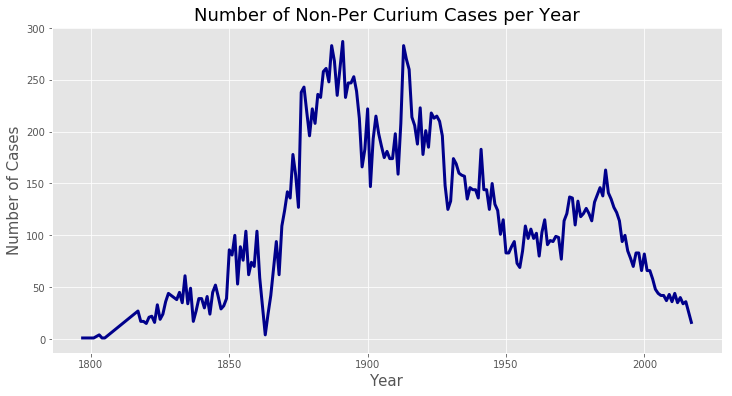

In [24]:
# Plot the number of cases seen per year

# There is only ever one majority opinion per case, while there can be zero to multiple dissenting. Thus, the case
# count will equal the number of majority opinions
majority_op = data_eda.loc[data_eda.category=='majority']
# Group the cases by year
ops_by_year = dict(majority_op.groupby('year')['name'].count())
# List and order the years in ascending order
yrs = list(majority_op.year.unique())
ord_yrs = sorted(yrs)

# Create a list for the case count for each year
counts = []
for yr in ord_yrs:
    number = ops_by_year[yr]
    counts.append(number)

# Plot the figure    
fig = plt.figure(figsize=[12,6])
plt.plot(ord_yrs, counts, lw=3, color='darkblue')
plt.title('Number of Non-Per Curium Cases per Year', fontsize=18)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of Cases', fontsize=15)
plt.show()

**Analysis:** In the early days of the court, few cases were heard as most of the justices were also serving as district/circuit court judges across the nation. The number of cases trends upward from the court's inception in 1789 up until roughly 1860, where the graph displays a sharp decline. This is most likely resulting from the beginning of the Civil War. This is also most likely the cause of the rapid increase in cases seen immediately following the dip. The cases argued before the court peaked between 1880 and 1930. The low case totals for the most recent year (2017) is misleading as this data was collected before the year was completed.

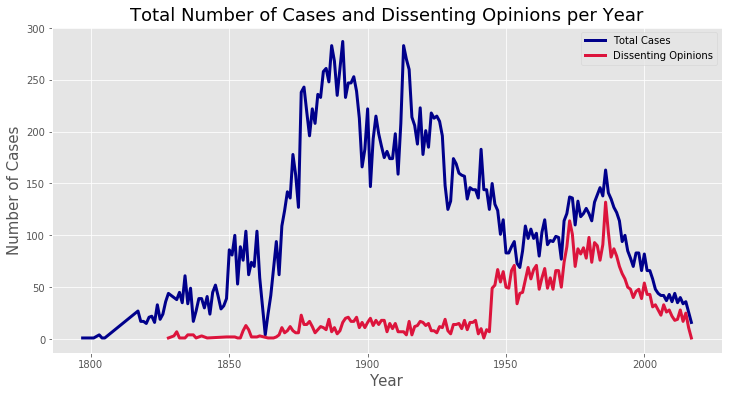

In [25]:
# Create a dataframe containing all of the dissenting and second dissenting opinions
dissenting_op = data_eda.loc[(data_eda.category=='dissenting') | (data_eda.category=='second_dissenting')]
# Group the cases by year
dis_ops_by_year = dict(dissenting_op.groupby('year')['name'].count())
# Create and order a list of the years in ascending order
dis_yrs = list(dissenting_op.year.unique())
dis_ord_yrs = sorted(dis_yrs)

# Get the count of dissenting opinions for ear year
dis_counts = []
for yr in dis_ord_yrs:
    number = dis_ops_by_year[yr]
    dis_counts.append(number)
    
# Combination of the previous graph to aid presentation/comparison of information

fig = plt.figure(figsize=[12,6])
plt.plot(ord_yrs, counts, lw=3, color='darkblue', label='Total Cases')
plt.plot(dis_ord_yrs, dis_counts, lw=3, color='crimson', label='Dissenting Opinions')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of Cases', fontsize=15)
plt.title('Total Number of Cases and Dissenting Opinions per Year', fontsize=18)
plt.legend()
plt.show()

**Analysis:** The graph suggests that there were relatively few dissenting arguments from the court until roughly 1940. This is interesting as the total number of cases was higher between the years of 1880 to 1940 than it was from the years of 1940 to present. While recent cases do have the benefit of a greater number of cases to serve as precedent, the sharp increase in dissenting opinions beginning aroung 1940 suggests there are multiple interpretations of the law.

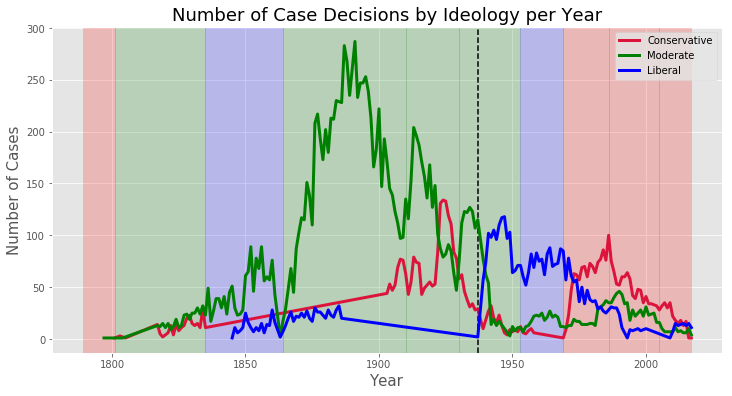

In [26]:
conservative = data_eda.loc[(data_eda.ideology_class == 'Conservative') & (data_eda.category == 'majority')]
moderate = data_eda.loc[(data_eda.ideology_class == 'Moderate') & (data_eda.category == 'majority')]
liberal = data_eda.loc[(data_eda.ideology_class == 'Liberal') & (data_eda.category == 'majority')]

con_grp = dict(conservative.groupby('year')['name'].count())
con_yrs = list(conservative.year.unique())
con_yrs = sorted(con_yrs)

con_counts = []
for yr in con_yrs:
    number = con_grp[yr]
    con_counts.append(number)

mod_grp = dict(moderate.groupby('year')['name'].count())
mod_yrs = list(moderate.year.unique())
mod_yrs = sorted(mod_yrs)

mod_counts = []
for yr in mod_yrs:
    number = mod_grp[yr]
    mod_counts.append(number)
    
lib_grp = dict(liberal.groupby('year')['name'].count())
lib_yrs = list(liberal.year.unique())
lib_yrs = sorted(lib_yrs)

lib_counts = []
for yr in lib_yrs:
    number = lib_grp[yr]
    lib_counts.append(number)
    
    
fig = plt.figure(figsize=[12,6])
plt.axvline(1937, color='black', linestyle='--')
plt.plot(con_yrs, con_counts, lw=3, color='crimson', label='Conservative')
plt.plot(mod_yrs, mod_counts, lw=3, color='green', label='Moderate')
plt.plot(lib_yrs, lib_counts, lw=3, color='blue', label='Liberal')
plt.axvspan(1789, 1801, color='red', alpha=0.2) # Jay, Rutledge, and Ellsworth Courts moderate?
plt.axvspan(1801, 1835, color='green', alpha=0.2) # Marshall Court
plt.axvspan(1835, 1864, color='blue', alpha=0.2) # Taney Court
plt.axvspan(1864, 1910, color='green', alpha=0.2) # Chase, Waite, and Fuller Courts
plt.axvspan(1910, 1930, color='green', alpha=0.2) # White and Taft Courts maybe blue/green
plt.axvspan(1930, 1953, color='green', alpha=0.2) # Hughes, Stone, and Vinson Courts
plt.axvspan(1953, 1969, color='blue', alpha=0.2) # Warren Court true moderate
plt.axvspan(1969, 1986, color='red', alpha=0.2) # Burger Court maybe true blue maybe true red
plt.axvspan(1986, 2005, color='red', alpha=0.2) # Rehnquist Court
plt.axvspan(2005, 2017, color='red', alpha=0.2) # Roberts Court true red
plt.title('Number of Case Decisions by Ideology per Year', fontsize=18)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of Cases', fontsize=15)
plt.legend()
plt.show()

**Analysis:** The number of majority opinions displayed by legal ideology of the author shows some interesting trends. First, the vast majority of the court opinion authors prior to 1940 held a moderate philosophy of law. In more recent years, the ideology of the authors are grouped into discrete sections. This is most likely a result of the tradition that the chief justice writes the majority opinion if they voted with the majority.

In [27]:
ideology_by_year = []
for yr in data_eda.year.unique():
    year_df = data_eda.loc[data_eda.year == yr]
    year_df = year_df.reset_index(drop=True)
    
    year_scores = []
    for i in list(range(0, len(year_df))):
        line = year_df.iloc[i]
        ideo_score = line.ideology_score
        if ideo_score != 888 and ideo_score != 777:
            ideo = ideo_score
        else:
            ideo = line.ideology_estimate
        year_scores.append(ideo)
        
    ideology_by_year.append([yr, round(np.mean(year_scores),4)])



score_by_year = []
for i in list(range(0, len(data_eda))):
    line = data_eda.iloc[i]
    yr = line.year
    for j in list(range(0,len(ideology_by_year))):
        #ideo_by_year = ideology_by_year[j]
        if yr == ideology_by_year[j][0]:
            score = ideology_by_year[j][1]
            score_by_year.append(score)
        else:
            continue

data_eda['court_ideology'] = score_by_year
data_eda.head()

,name,year,category,text,amendment,ideology_score,ideology_estimate,ideology_class,decision_direction,minority_votes,court_ideology
0,"Roberts, John G., Jr.",2014,majority,There is no right more basic in our democracy ...,First,0.12,0.2805,Conservative,1.0,4.0,0.3787
1,"Taney, Roger Brooke",1841,majority,This case was brought here by an appeal from t...,None,888.00,0.6055,Moderate,2.0,0.0,0.5456
2,"Pitney, Mahlon",1914,majority,"Plaintiff in error, who was plaintiff below, c...",Fifth,888.00,0.4075,Moderate,1.0,1.0,0.3730
3,"Harlan, John Marshall (I)",1882,majority,Whether the State court or the Circuit Court o...,None,888.00,0.4407,Moderate,1.0,0.0,0.4293
4,"Miller, Samuel Freeman",1889,majority,This is a writ of error to the Circuit Court o...,None,888.00,0.4095,Moderate,3.0,0.0,0.4499


In [28]:
sort_score_year = sorted(ideology_by_year, key=lambda x: x[0])


sort_yr = []
sort_score = []

for i in list(range(0,len(sort_score_year))):
    year = sort_score_year[i][0]
    ideo_score = sort_score_year[i][1]
    sort_yr.append(year)
    sort_score.append(ideo_score)

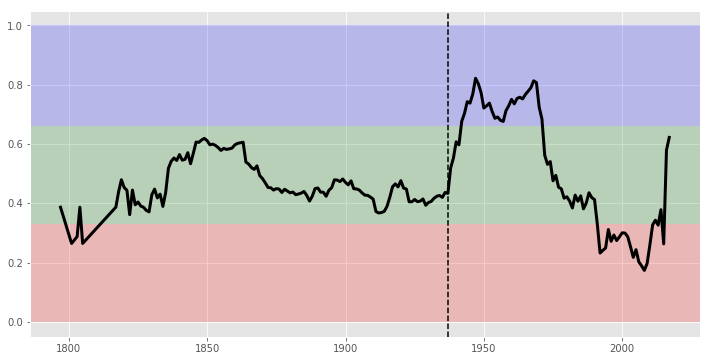

In [32]:
fig = plt.figure(figsize=[12,6])
plt.plot(sort_yr, sort_score, color='black', lw=3)
plt.axvline(1937, color='black', linestyle='--')
plt.axhspan(0, 0.33, facecolor='red', alpha=0.2)
plt.axhspan(0.33, 0.66, facecolor='green', alpha=0.2)
plt.axhspan(0.66, 1, facecolor='blue', alpha=0.2)
plt.show()

**Analysis:** The graph displays the average ideology score for the justices serving on the court by year. The average ideology scores prior to 1937 are mostly moderate and more stable than the recent ideology scores. This supports the recent increase in dissenting opinions as the court is seeming to fluctuate between the ideological extremes.

In [33]:
# Formating amendment matches from regex pattern search

data_eda.loc[(data_eda.amendment == 'First') | (data_eda.amendment == '1st'), 'amendment'] = 1
data_eda.loc[(data_eda.amendment == 'Second') | (data_eda.amendment == '2nd'), 'amendment'] = 2
data_eda.loc[(data_eda.amendment == 'Third') | (data_eda.amendment == '3rd'), 'amendment'] = 3
data_eda.loc[(data_eda.amendment == 'Fourth') | (data_eda.amendment == '4th'), 'amendment'] = 4
data_eda.loc[(data_eda.amendment == 'Fifth') | (data_eda.amendment == '5th'), 'amendment'] = 5
data_eda.loc[(data_eda.amendment == 'Sixth') | (data_eda.amendment == '6th'), 'amendment'] = 6
data_eda.loc[(data_eda.amendment == 'Seventh') | (data_eda.amendment == '7th'), 'amendment'] = 7
data_eda.loc[(data_eda.amendment == 'Eighth') | (data_eda.amendment == '8th'), 'amendment'] = 8
data_eda.loc[(data_eda.amendment == 'Ninth') | (data_eda.amendment == '9th'), 'amendment'] = 9
data_eda.loc[(data_eda.amendment == 'Tenth') | (data_eda.amendment == '10th'), 'amendment'] = 10
data_eda.loc[(data_eda.amendment == 'Eleventh') | (data_eda.amendment == '11th'), 'amendment'] = 11
data_eda.loc[(data_eda.amendment == 'Twelfth') | (data_eda.amendment == '12th'), 'amendment'] = 12
data_eda.loc[(data_eda.amendment == 'Thirteenth') | (data_eda.amendment == '13th'), 'amendment'] = 13
data_eda.loc[(data_eda.amendment == 'Fourteenth') | (data_eda.amendment == '14th'), 'amendment'] = 14
data_eda.loc[(data_eda.amendment == 'Fifteenth') | (data_eda.amendment == '15th'), 'amendment'] = 15
data_eda.loc[(data_eda.amendment == 'Sixthteenth') | (data_eda.amendment == '16th'), 'amendment'] = 16
data_eda.loc[(data_eda.amendment == 'Seventeenth') | (data_eda.amendment == '17th'), 'amendment'] = 17
data_eda.loc[(data_eda.amendment == 'Eighteenth') | (data_eda.amendment == '18th'), 'amendment'] = 18
data_eda.loc[(data_eda.amendment == 'Nineteenth') | (data_eda.amendment == '19th'), 'amendment'] = 19
data_eda.loc[(data_eda.amendment == 'Twentieth') | (data_eda.amendment == '20'), 'amendment'] = 20
data_eda.loc[(data_eda.amendment == 'first') | (data_eda.amendment == '21st'), 'amendment'] = 21
data_eda.loc[(data_eda.amendment == 'second') | (data_eda.amendment == '22nd'), 'amendment'] = 22
data_eda.loc[(data_eda.amendment == 'third') | (data_eda.amendment == '23rd'), 'amendment'] = 23
data_eda.loc[(data_eda.amendment == 'fourth') | (data_eda.amendment == '24th'), 'amendment'] = 24
data_eda.loc[(data_eda.amendment == 'fifth') | (data_eda.amendment == '25th'), 'amendment'] = 25
data_eda.loc[(data_eda.amendment == 'sixth') | (data_eda.amendment == '26th'), 'amendment'] = 26
data_eda.loc[(data_eda.amendment == 'seventh') | (data_eda.amendment == '27th'), 'amendment'] = 27
data_eda.loc[(data_eda.amendment == 'eighth') | (data_eda.amendment == '28th'), 'amendment'] = 28

In [34]:
# Create a dataframe where the amendments mentioned in the case opinions could be reliably determined

amendment_df = data_eda.loc[(data_eda.amendment == 1) | (data_eda.amendment == 2) | (data_eda.amendment == 3) |
                           (data_eda.amendment == 4) | (data_eda.amendment == 5) | (data_eda.amendment == 6) |
                           (data_eda.amendment == 7) | (data_eda.amendment == 8) | (data_eda.amendment == 9) |
                           (data_eda.amendment == 10) | (data_eda.amendment == 11) | (data_eda.amendment == 12) |
                           (data_eda.amendment == 13) | (data_eda.amendment == 14) | (data_eda.amendment == 15) |
                           (data_eda.amendment == 16) | (data_eda.amendment == 17) | (data_eda.amendment == 18) |
                           (data_eda.amendment == 19) | (data_eda.amendment == 20) | (data_eda.amendment == 21) |
                           (data_eda.amendment == 22) | (data_eda.amendment == 23) | (data_eda.amendment == 24) |
                           (data_eda.amendment == 25) | (data_eda.amendment == 26) | (data_eda.amendment == 27) |
                           (data_eda.amendment == 28)]

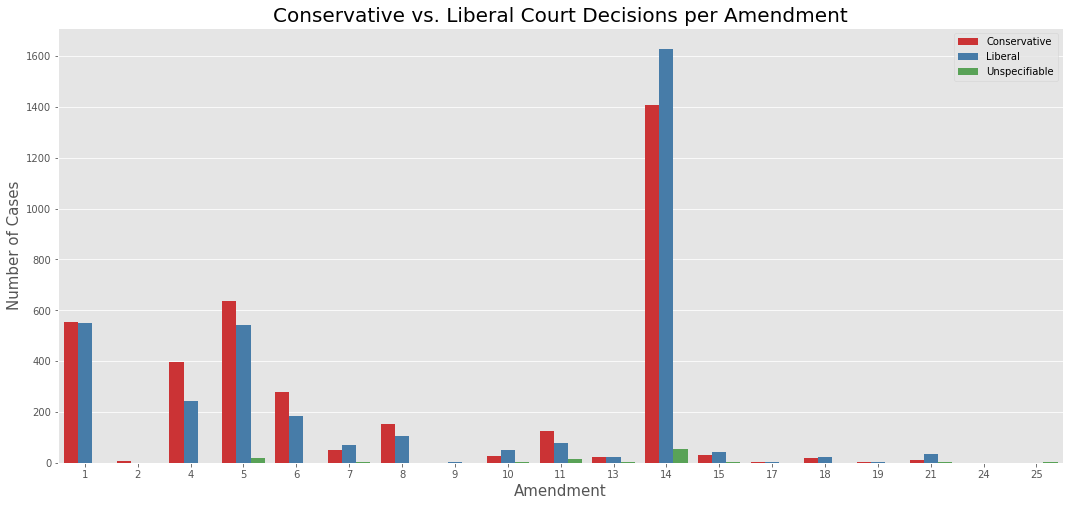

In [37]:
fig = plt.figure(figsize=[18,8])
sns.countplot(x='amendment', data=amendment_df, palette='Set1', hue='decision_direction')
plt.xlabel('Amendment', fontsize=15)
plt.ylabel('Number of Cases', fontsize=15)
plt.title('Conservative vs. Liberal Court Decisions per Amendment', fontsize=20)
L = plt.legend(loc='upper right')
L.get_texts()[0].set_text('Conservative')
L.get_texts()[1].set_text('Liberal')
L.get_texts()[2].set_text('Unspecifiable')
plt.show()

**Analysis:** The graph displays the number of case decisions per amendment based on whether the decision is classified as conservative, liberal, or unspecifiable by the Supreme Court Database (cited previously). The 1st, 5th, and 14th Amendments have seen the most action in the Supreme Court. While these cases are the most numerous, the direction of their decisions are relatively equal. These three amendments will be the focus of further analysis.

The results for the second amendment case counts are actually true: http://www2.law.ucla.edu/volokh/beararms/sct.htm

Explanation of decision direction values: http://scdb.wustl.edu/documentation.php?var=decisionDirection

In [38]:
amendments = sorted(amendment_df.amendment.unique())
@interact
def decision_by_amendment(num_amend=amendments):
    amend_df = amendment_df.loc[(amendment_df.amendment==num_amend) & (amendment_df.category=='majority')]

    con = amend_df.loc[amend_df.decision_direction==1]
    lib = amend_df.loc[amend_df.decision_direction==2]


    con_ops_by_year = dict(con.groupby('year')['name'].count())
    con_yrs = list(con.year.unique())
    con_ord_yrs = sorted(con_yrs)

    con_counts = []
    for yr in con_ord_yrs:
        number = con_ops_by_year[yr]
        con_counts.append(number)
    
    lib_ops_by_year = dict(lib.groupby('year')['name'].count())
    lib_yrs = list(lib.year.unique())
    lib_ord_yrs = sorted(lib_yrs)

    lib_counts = []
    for yr in lib_ord_yrs:
        number = lib_ops_by_year[yr]
        lib_counts.append(number)
    
# plt.style.use('ggplot')

    if num_amend == 1 or num_amend == 21:
        title = f"Conservative vs. Liberal {num_amend}st Amendment Case Decisions per Year"
    elif num_amend == 2:
        title = f"Conservative vs. Liberal {num_amend}nd Amendment Case Decisions per Year"
    elif num_amend == 3:
        title = f"Conservative vs. Liberal {num_amend}rd Amendment Case Decisions per Year"
    else:
        title = f'Conservative vs. Liberal {num_amend}th Amendment Case Decisions per Year'
    
    fig = plt.figure(figsize=[12,6])
    plt.plot(con_ord_yrs, con_counts, lw=3, color='crimson', label='Conservative')
    plt.plot(lib_ord_yrs, lib_counts, lw=3, color='blue', label='Liberal')
    plt.title(title, fontsize=18)
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Number of Decisions', fontsize=15)
    plt.legend()
    plt.show()

interactive(children=(Dropdown(description='num_amend', options=(1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1…

## 2b. Ideological Evaluation of the Class Corpuses
As text analysis requires additional cleaning, preprocessing, and manipulation, the first several code blocks will create a corpus-specific stopwords list and define necessary functions. The data will first be analyzed with the ScatterText package (https://github.com/JasonKessler/scattertext) to assertain the differences in the case opinions from conservative and liberal justices. Then, the vector space of the word embeddings for each ideological class will be examined to further illustrate any differences.

In [39]:
# Create a list of nltk stopwords
stopwords_list = stopwords.words('english')

# Add all punctuation to the stopwords list
stopwords_list += list(string.punctuation)

# Add line breaks to stopwords_list
stopwords_list += ["\n", "\t", "[\]"]

# Add capitalized and all caps justice names to the stopword list (in case the model uses the justice names, instead
# of case opinion text to determine ideological class)

## List of unique last names from the ideology dataset
ideo_names = ideology.last_name.unique()

## List of unique last names from the data dataset
data_names = data.last_name.unique()

## List comprehension to create list of items that did not match between the two lists
surnames = [name for name in data_names if name in ideo_names]

stopwords_list += surnames

stopwords_list += ["''", '``','the','court', "'s", "v.", 'u.s.', "state", "would", "states", "act", "case",
                 "§","united","supreme", "may", "one", 'it', 'in', 'U.S.', 'State', 'States', 'Would', 
                 "Act", 'Case', 'United', 'Supreme', 'V.', 'Mr.', 'mr.', 'Justice', 'justice']


cap_stop = stopwords.words('english')
stopwords_list += [word.capitalize() for word in cap_stop]

# Create two verisons of the surname list, capitalize the first letter and capitalize every word (based on the how
# the names of justices appeared in the texts sampled during initial exploration)

###Actually, unecessary because keras tokenize lower=True converts all tokens to lowercase
surname_proper = [name.capitalize() for name in surnames]
# surname_caps = [name.upper() for name in surnames]

# Append the two capitalization variations lists to the stopwords list
stopwords_list += surname_proper
# stopwords_list += surname_caps

# Create single string of all stopwords to pass a filter with keras tokenizer (might as well while we're here)
joined_stop = ''.join(tok for tok in stopwords_list)

In [40]:
def tokenize_and_stop (text):
    '''Text preprocessing function that takes in a raw text document, tokenizes it, converts all tokens to lowercase,
    and removes stopwords. This function was designed to be used in the form of DataFrame['col_name'].map(function).
    
    text: string, raw text document as an instance in a pandas dataframe
    
    returns the tokenized and stopped text as a list of tokens
    
    '''
    
    # Use nltk word_tokenize function on the input text
    data_text = word_tokenize(text)
    
    # Convert all tokens to lowercase and remove stopwords
    data_stopped = [tok.lower() for tok in data_text if tok not in stopwords_list]
    
    return data_stopped

In [41]:
def create_vector_df(vector_df):
    '''This function converts a dataframe where each instance is the vector for a particular word in the form of a
    list into a dataframe where each column represents a dimension from the vector. The function assumes all vectors
    are the same shape. Designed to be used as a helper function with the get_spacy_vectors function.
    
    vector_df: a column from a pandas dataframe where each row contains a word vector in the form of a python list
    
    returns a pandas dataframe where each column represents one of the dimensions from the vector and each row is 
    an individual vector
    
    '''
    
    # List to hold individual, transposed vectors
    df = []
    # Loop through each instance
    for i in list(range(0,len(vector_df.vector))):
        # Put vector into a dataframe and transpose; (n,1) --> (1,n)
        vectors = pd.DataFrame(vector_df.vector[i]).T
        # Store individual, transposed vector in a list for subsequent concatenation
        df.append(vectors)
    # Combine all individual, transposed vectors into a single dataframe
    vecs_df = pd.concat(df, axis=0)
    
    return vecs_df

In [42]:
def get_spacy_vectors(text):
    '''Function designed to grab the english SpaCy vectors for the words in a specific corpus and return them in a
    dataframe where each row corresponds to a specific vector and where each column represents one of the dimensions 
    of the vector.
    
    text: tokenized string; designed to take in a column from a pandas dataframe with tokenized texts as intances
    
    returns a pandas dataframe where each column represents one of the dimensions from the vector and each row is 
    an individual vector
    
    '''
    # Instantiate a dictionary to hold word vectors
    word_vecs = {}
    
    # Loop through each tokenized document in the input text
    for doc in text:
        # Loop through each token in the text instance
        for word in doc:
            # Conditional to detemine if the text instance word is in SpaCy's embedded vocabulary
            if word in nlp.vocab:
                # Create a word:vector entry in the word_vecs dictionary
                word_vecs[word] = nlp.vocab[word].vector
            # Discard the text instance word if not in SpaCy's embedded vocabulary
            else:
                continue
    # Create a dataframe where each instance holds the word's vector as a list
    vec_df = pd.DataFrame()
    vec_df['vector'] = [word_vecs[x] for x in list(word_vecs.keys())]
    vec_df['word'] = [x for x in list(word_vecs.keys())]
    
    # Use the create_vector_df helper function to convert the vectors stored as lists into their own dataframe
    vectors_df = create_vector_df(vec_df)
    
    return vectors_df

In [43]:
def pca_3d(vecs1, vecs2, vecs3, title, elev=None, rotate=None):
    ''' Function designed to reduce (via PCA) the high-dimensional word vectors to three dimensions with the intention
    of plotting their relationship. 
    
    vecs1, vecs2, vecs3: pandas dataframe containing the word vectors where each row represents and entire vector
    and each column represents a dimension of the vectors
    
    title: string denoting the title of the plot
    
    elev: integer pertaining to what elevation to apply to the view of the 3d plot
    
    rotate: integer pertaining to what angle to apply to the view of the 3d plot
    
    returns a three dimensional plot at the specified viewing angle where vecs1 is red, vecs2 is green, and vecs3 is 
    blue
    
    '''
    
    # Perform PCA on the three vector dfs
    pca = PCA(n_components=3)
    vecs1_pca = pca.fit_transform(vecs1)
    vecs2_pca = pca.fit_transform(vecs2)
    vecs3_pca = pca.fit_transform(vecs3)
    
    # Create a new dataset for the 3 principal components for the three PCA'd vectors
    vecs1_results = pd.DataFrame(data = vecs1_pca , columns = ['PC1', 'PC2', 'PC3'])
    vecs2_results = pd.DataFrame(data=vecs2_pca, columns=['PC1', 'PC2', 'PC3'])
    vecs3_results = pd.DataFrame(data=vecs3_pca, columns=['PC1', 'PC2', 'PC3'])
    
    # Plot the figure at the specified viewing angle
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vecs1_results['PC1'], vecs1_results['PC2'], vecs1_results['PC3'], c='crimson')
    ax.scatter(vecs2_results['PC1'], vecs2_results['PC2'], vecs2_results['PC3'], c='green')
    ax.scatter(vecs3_results['PC1'], vecs3_results['PC2'], vecs3_results['PC3'], c='darkblue')
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.view_init(elev, rotate)
    
    plt.show()

In [44]:
#### Create a dataframe of case opinions to use for analysis with the ScatterText package

# Create a dataframe of the case opinions from the conservative and liberal ideological classes
text_df = data_eda.loc[(data_eda.ideology_class == 'Conservative') | (data_eda.ideology_class == 'Liberal')]
text_df = text_df[['name', 'text', 'ideology_class']]

# Create a small sample because these figures take some time to produce
text_sample_df = text_df.sample(frac=0.02)
print(text_sample_df.shape)
text_sample_df.head()

(296, 3)


,name,text,ideology_class
30719,"Marshall, Thurgood",Section 8 (a) (3) of the National Labor Relati...,Liberal
25666,"Sutherland, George",This case is here both by writ of error and ap...,Conservative
27970,"Douglas, William Orville","This suit, removed from a Vermont court to the...",Liberal
10246,"Douglas, William Orville",This case is a companion case to Williams v. K...,Liberal
5465,"Black, Hugo Lafayette",Korematsu was found guilty by the District Cou...,Liberal


In [41]:
# Note that with 2% of the data (~300 instances), this cell took around 2 mins to run

# Create a corpus of the case opinions from the sampled data
corpus = st.CorpusFromPandas(text_sample_df, category_col='ideology_class', text_col='text', nlp=nlp).build()


In [44]:
# Produce the interactive plot
html = st.produce_scattertext_explorer(corpus, category='Liberal', category_name='Liberal',
                                       not_category_name='Conservative', width_in_pixels=1000,
                                       minimum_term_frequency=5, metadata=text_sample_df['name'])
# # Unhash to open the html file inline; currently hashed to keep my computer alive
# file_name = 'st_jitter_points.html'
# open(file_name, 'wb').write(html.encode('utf-8'))
# IFrame(src=file_name, width = 1000, height=700)

**Analysis:** The main areas of focus for this graph are the upper left and lower right corners. The upper left corner represents the high-frequency words for the case opinions authored by liberal justices while the lower right corner represents the high-frequency words for the case opinions authored by conservative justices.

In [45]:
# Produce the interactive plot
html = st.produce_scattertext_explorer(corpus, category='Liberal', category_name='Liberal',
                                       not_category_name='Conservative', width_in_pixels=1000,
                                       metadata=text_sample_df['name'],
                                       transform=st.Scalers.log_scale_standardize)
# # Unhash to open the html file inline; currently hashed to keep my computer alive
# file_name = 'st_log_scale.html'
# open(file_name, 'wb').write(html.encode('utf-8'))
# IFrame(src=file_name, width = 1000, height=700)

**Analysis:** Graph displays the characteristic terms found in the case opinions separated by ideology.

In [46]:
text_sample_df['parsed'] = text_sample_df.text.apply(nlp)

In [52]:
# Instantiate an object to extract topics and categories, rather than words/bigrams
feat_builder = st.FeatsFromSpacyDocAndEmpath()

# Build a corpus for the topics/categories
empath_corpus = st.CorpusFromParsedDocuments(text_sample_df, category_col='ideology_class',
                                             feats_from_spacy_doc=feat_builder, parsed_col='parsed').build()
# Produce the interactive plot
html = st.produce_scattertext_explorer(empath_corpus, category='Liberal', category_name='Liberal',
                                       not_category_name='Conservative', width_in_pixels=900,
                                       metadata=text_sample_df['name'], use_non_text_features=True,
                                       use_full_doc=True,
                                       topic_model_term_lists=feat_builder.get_top_model_term_lists())

# # Unhash to open the html file and display the plot inline; currently hashed to keep my computer alive
# file_name = 'st_empath.html'
# open(file_name, 'wb').write(html.encode('utf-8'))
# IFrame(src=file_name, width = 900, height=700)

**Analysis:**

In [53]:
# Create a corpus for how a much a word/term is characteristic of a specific ideological class
corpus2 = (st.CorpusFromPandas(text_sample_df,
                              category_col='ideology_class',
                              text_col='text',
                              nlp=st.whitespace_nlp_with_sentences).build().get_unigram_corpus()
           .compact(st.ClassPercentageCompactor(term_count=2,
                                               term_ranker=st.OncePerDocFrequencyRanker)))
# Produce the interactive plot
html = st.produce_characteristic_explorer(corpus2,category='Liberal', category_name='Liberal',
                                          not_category_name='Conservative',
                                          metadata=corpus2.get_df()['name'])


# # Unhash to O]open the html file and display inline; currently hashed to keep my computer alive
# file_name = 'test5_visual.html'
# open(file_name, 'wb').write(html.encode('utf-8'))
# IFrame(src=file_name, width = 900, height=700)

**Analysis:**

In [54]:
# Isolate the conservative, moderate, and liberal case opinions
conserv = data_eda.loc[data_eda.ideology_class == 'Conservative']
moderate = data_eda.loc[data_eda.ideology_class == 'Moderate']
liberal = data_eda.loc[data_eda.ideology_class == 'Liberal']

# Sample a smaller portion of the data in the interest of time
sample_conserv = conserv.sample(frac=0.2, random_state=16)
print(len(sample_conserv))
sample_moderate = moderate.sample(frac=0.1, random_state=16) #case opinions from moderate justices 2x other ideologies
print(sample_moderate)
sample_liberal = moderate.sample(frac=0.2, random_state=16)
print(sample_liberal)


In [55]:
# Create a new column in each df to hold its processed texts
sample_conserv['processed'] = sample_conserv['text'].map(tokenize_and_stop)
sample_moderate['processed'] = sample_moderate['text'].map(tokenize_and_stop)
sample_liberal['processed'] = sample_liberal['text'].map(tokenize_and_stop)

In [56]:
# Create the word vector dataframes for each ideological class
con_vecs = get_spacy_vectors(sample_conserv.processed)
mod_vecs = get_spacy_vectors(sample_moderate.processed)
lib_vecs = get_spacy_vectors(sample_liberal.processed)

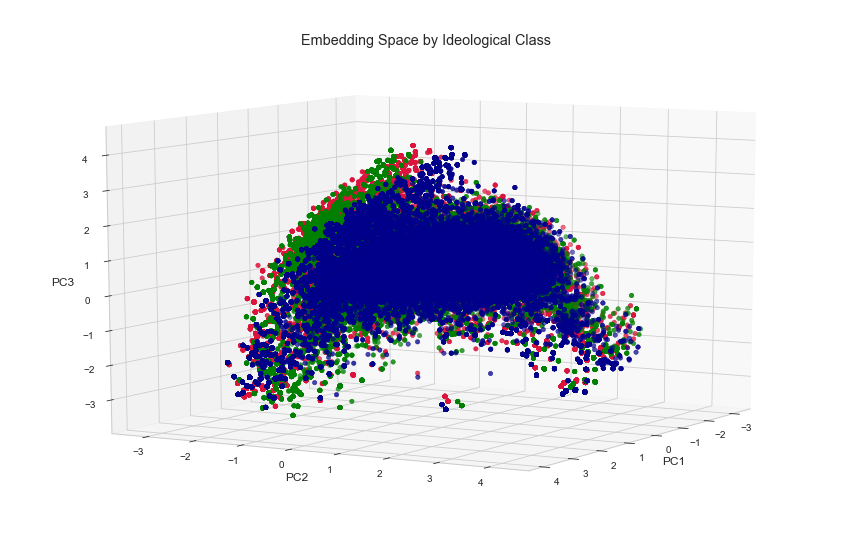

In [61]:
plt.style.use('seaborn-whitegrid')
# Visualize the word embedding vectors after undergoing PCA
pca_3d(con_vecs, mod_vecs, lib_vecs, title='Three Principal Component Embedding Space by Ideological Class', 
       elev=10, rotate=30)

**Analysis:** The plot displays the word vectors for the three ideological classes after undergoing PCA to reduces the 300 dimensional vectors down to the first three principal components. There does not seem to be much difference overall between the three classes, but there may be some evidence of separation along the upper left edge of the main blob as the liberal vectors seem to be slightly shifted towards the right.

In [62]:
# Isolate the case opinions for ideology pertaining to the First Amendment
con_amend1 = conserv.loc[conserv.amendment == 1]
mod_amend1 = moderate.loc[moderate.amendment == 1]
lib_amend1 = liberal.loc[liberal.amendment == 1]

# Create a new column in each dataframe to hold its processed texts
con_amend1['processed'] = con_amend1['text'].map(tokenize_and_stop)
mod_amend1['processed'] = mod_amend1['text'].map(tokenize_and_stop)
lib_amend1['processed'] = lib_amend1['text'].map(tokenize_and_stop)

In [63]:
# Create the word vector dataframes for each ideological class
con1_vecs = get_spacy_vectors(con_amend1.processed)
mod1_vecs = get_spacy_vectors(mod_amend1.processed)
lib1_vecs = get_spacy_vectors(lib_amend1.processed)

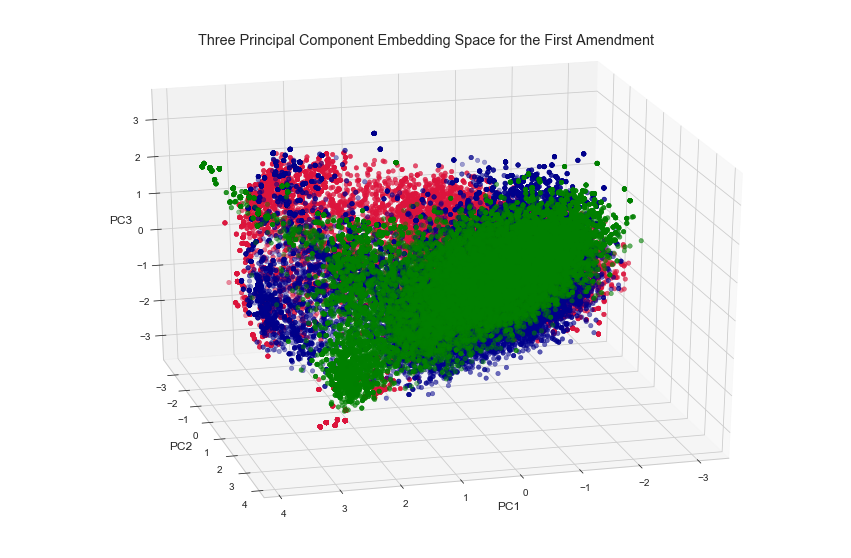

In [66]:
# Visualize the word embedding vectors after undergoing PCA
pca_3d(con1_vecs, mod1_vecs, lib1_vecs, 'Three Principal Component Embedding Space for the First Amendment', 25, 75)

**Analysis:** Again, the evidence of ideological class separation is weak. But, there may be evidence that the conservative ideology word vectors cluster slightly higher in the along the third principal component from the other two ideologies for the 1st Amendment case opinions.

In [67]:
# Isolate the case opinions for each ideology pertaining to the Fifth Amendment
con_amend5 = conserv.loc[conserv.amendment == 5]
mod_amend5 = moderate.loc[moderate.amendment == 5]
lib_amend5 = liberal.loc[liberal.amendment == 5]

# Create a new column in each dataframe to hold its processed texts
con_amend5['processed'] = con_amend5['text'].map(tokenize_and_stop)
mod_amend5['processed'] = mod_amend5['text'].map(tokenize_and_stop)
lib_amend5['processed'] = lib_amend5['text'].map(tokenize_and_stop)

In [68]:
# Create the word vector dataframes for each ideological class
con5_vecs = get_spacy_vectors(con_amend5.processed)
mod5_vecs = get_spacy_vectors(mod_amend5.processed)
lib5_vecs = get_spacy_vectors(lib_amend5.processed)

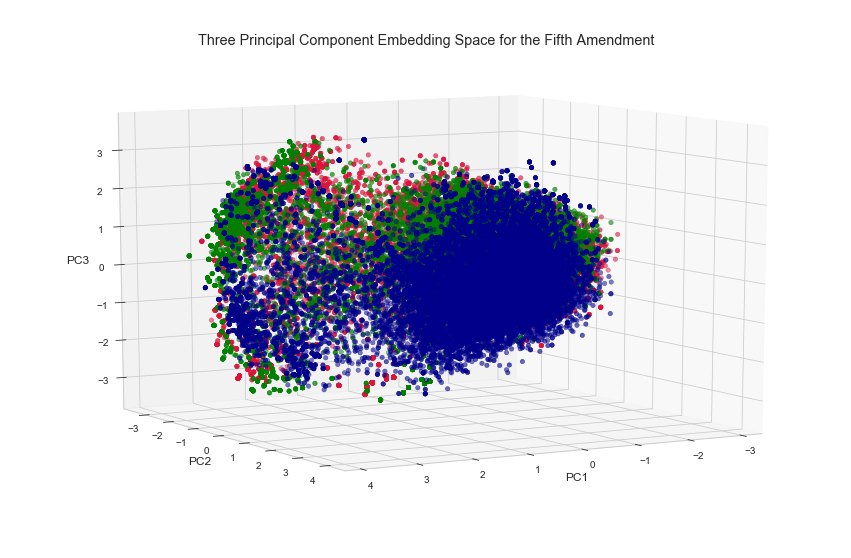

In [69]:
# Visualize the word embedding vectors after undergoing PCA
pca_3d(con5_vecs, mod5_vecs, lib5_vecs, 'Three Principal Component Embedding Space for the Fifth Amendment', 10, 60)

**Analysis:** While there doesn't appear to be evidence that there are distinct clusters representing the three ideological classes, it does appear that there are two groups each with representation from the three ideologies. There appears to be a denser group to the right and then a smaller grouping to the left. These grouping may represent different case topics that fall within the Fifth Amendment.

In [72]:
# Isolate the case opinions for ideology pertaining to the Fifth Amendment
con_amend14 = conserv.loc[conserv.amendment == 14]
mod_amend14 = moderate.loc[moderate.amendment == 14]
lib_amend14 = liberal.loc[liberal.amendment == 14]

# Sample a smaller portion of the data in the interest of time
conserv14_sample = con_amend14.sample(frac=0.2, random_state=16)
print(len(conserv14_sample))
moderate14_sample = mod_amend14.sample(frac=0.15, random_state=16) # case opinions from moderate justices occur 2:1 
                                                                  # to other ideologies
print(len(moderate14_sample))
liberal14_sample = lib_amend14.sample(frac=0.25, random_state=16)
print(len(liberal14_sample))

# Create a new column in each dataframe to hold its processed texts
conserv14_sample['processed'] = conserv14_sample['text'].map(tokenize_and_stop)
moderate14_sample['processed'] = moderate14_sample['text'].map(tokenize_and_stop)
liberal14_sample['processed'] = liberal14_sample['text'].map(tokenize_and_stop)

201
198
218


In [73]:
# Create the word vector dataframes for each ideological class
con14_vecs = get_spacy_vectors(conserv14_sample.processed)
mod14_vecs = get_spacy_vectors(moderate14_sample.processed)
lib14_vecs = get_spacy_vectors(liberal14_sample.processed)

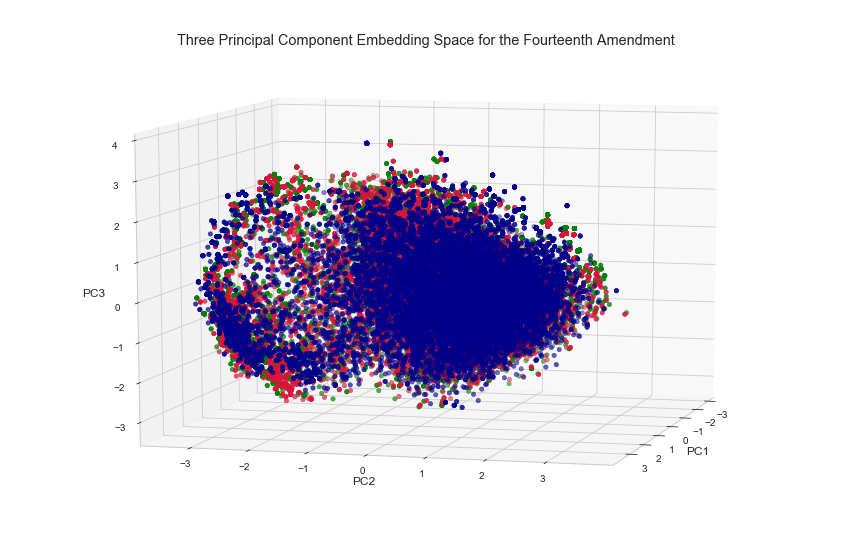

In [74]:
pca_3d(con14_vecs, mod14_vecs, lib14_vecs, 'Three Principal Component Embedding Space for the Fourteenth Amendment', 
       10, 15)

**Analysis:** Still it is difficult to suggest that there are clear classes based on the word vector embeddings for the 14th Amendment case opinions. It is interesting to note that there appears to be a subgroup within the 14th Amendment case opinions, which was also present in the word vector embeddings of the 5th Amendment case opinions.

## Conclusion

Despite multiple efforts, clear distictions between the three ideological classes could not be definatively visualized. It will be interesting to see how the different classes of models perform on this classification task as visual techniques failed to separate the data by class. However, we are only able to visualize data in at best 3-dimensions and the class separation may be more distinct in higher dimensions.

# 3. Model development
- Isolate text and labels
- split into train/test/validation
- tokenize text (lim 26000 words)
- text to sequences
- pad (based on mean length of stopped case opinion)
- baseline model
- regularization

In [94]:
def preprocess (data_df, fraction, stop=False, max_seq_len=1000):
    '''Process data for kera text classification. Takes in a dataframe containing raw text and their corresponding
    labels. Returns a tokenized and padded sequences for training and test sets, along with their one-hot encoded
    labels.
    
    data_df: pandas dataframe containing the raw texts and labels
    
    fraction: float between 0 and 1 pertaining to the percentage of the data_df to sample and preprocess
    
    stop: boolean to include stopwords in filter; default == False
    
    max_seq_len: integer specifying the maximum length of the tokenized sequences during padding; default == 1000
    
    returns tokenized and padded sequences for training and test sets, along with one-hot encoded labels in the order
    of train_x, test_x, train_y, test_y
    
    '''
    # Sample the data according to specified percentage
    data_sample = data_df.sample(frac=fraction, random_state=16)
    
    # Split the data into a training and test set
    train_X, test_X, train_Y, test_Y = train_test_split(data_sample.text, data_sample.ideology_class, test_size=0.2,
                                                       random_state=16)
    
    ## Convert labels to dummie values (formatting for keras model use of categorical_crossentropy)
    train_y = pd.get_dummies(train_Y)
    test_y = pd.get_dummies(test_Y)
    
    # Conditional to deal with if the data should have stopwords removed
    if stop == True:
        # Get a list of training instances
        list_train_texts = train_X.values
        # Instantiate a tokenizer to convert words to tokens, filter out stopwords, and lowercase all tokens
        tokenizer = text.Tokenizer(num_words=26000, lower=True, filters=joined_stop)
        # Fit the tokenizer to the training data
        tokenizer.fit_on_texts(list(list_train_texts))
        # Convert the tokenized words to a sequence (for recurrent/bidirectional modeling)
        list_tokenized_train = tokenizer.texts_to_sequences(list_train_texts)
        # Get a list of testing instances
        list_test_texts = test_X.values
        # Fit the tokenizer on the testing data
        tokenizer.fit_on_texts(list(list_test_texts))
        # Convert the tokenized words to a sequence (for recurrent/bidirectional modeling)
        list_tokenized_test = tokenizer.texts_to_sequences(list_test_texts)
        
        # Pad the tokenized sequences to the specified length
        train_x_tokenized = sequence.pad_sequences(list_tokenized_train, maxlen=max_seq_len)
        test_x_tokenized = sequence.pad_sequences(list_tokenized_test, maxlen=max_seq_len)
        
    # Conditional to deal with if the data should not have stopwords removed
    else:
        # Get a list of training instances
        list_train_texts = train_X.values
        # Instantiate a tokenizer to convert words to tokens and lowercase all tokens
        tokenizer = text.Tokenizer(num_words=26000, lower=True)
        # Fit the tokenizer to the training data
        tokenizer.fit_on_texts(list(list_train_texts))
        # Convert the tokenized words to a sequence (for recurrent/bidirectional modeling)
        list_tokenized_train = tokenizer.texts_to_sequences(list_train_texts)
        # Get a list of testing instances
        list_test_texts = test_X.values
        # Fit the tokenizer on the testing data
        tokenizer.fit_on_texts(list(list_test_texts))
        # Convert the tokenized words to a sequence (for recurrent/bidirectional modeling)
        list_tokenized_test = tokenizer.texts_to_sequences(list_test_texts)
        
        # Pad the tokenized sequences to the specified length
        train_x_tokenized = sequence.pad_sequences(list_tokenized_train, maxlen=max_seq_len)
        test_x_tokenized = sequence.pad_sequences(list_tokenized_test, maxlen=max_seq_len)
    
    return train_x_tokenized, test_x_tokenized, train_y, test_y

In [76]:
def model_performance(model_history):
    '''Create two subplots to display the loss and accuracy changes during model training for both the training and
    validation sets.
    
    model_history: keras model.fit object storing the model performance metrics across training epochs
    
    returns two subplots displaying the loss and accuracy of the model across training epochs for both the training
    and validation sets. Training values are displayed in red and validation values are displayed in blue.
    '''
    # Create a variable to work with the model history
    history_dict = model_history.history
    # Isolate the model's loss measures over the course of training
    loss_values = history_dict['loss']
    # Isolate the model's loss measures over the course of validation
    val_loss_values = history_dict['val_loss']
    
    # Variable to set the plot's X values
    epochs = range(1, len(loss_values) + 1)
    
    # Instantiate the subplots
    fig, ax = plt.subplots(1, 2, figsize=[25,10])
    
    # Format the training/validation loss plot
    ax[0].plot(epochs, loss_values, 'red', label='Training loss')
    ax[0].plot(epochs, val_loss_values, 'blue', label='Validation loss')
    ax[0].set_title('Training and Validation loss', fontsize=20)
    ax[0].set_xlabel('Epochs', fontsize=16)
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].legend()
    
    
    # Isolate the model's accuracy measures over the course of training
    acc_values = history_dict['acc']
    # Isolate the model's accuracy measures over the course of validation
    val_acc_values = history_dict['val_acc'] 
    
    # Format the training/validation accuracy plot
    ax[1].plot(epochs, acc_values, 'red', label='Training acc')
    ax[1].plot(epochs, val_acc_values, 'blue', label='Validation acc')
    ax[1].set_title('Training and Validation accuracy', fontsize=20)
    ax[1].set_xlabel('Epochs', fontsize=16)
    ax[1].set_ylabel('Accuracy', fontsize=16)

    plt.legend()

    plt.show()

In [77]:
#cnf_matrix = confusion_matrix(y_hat_test, y_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    
    '''Create a confusion matrix to visualize model performance on testing data.
    
    cm: an SKLearn confusion matrix
    classes: list of class names to use as x and y tick labels; list of strings
    normalize: boolean to normalize values (integers for count --> percentage)
    cmap: matplotlib color map to use for plot
    
    returns a matplotlib plot of a confusion matrix
    
    '''
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    # Create/format confusion matrix plot
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [78]:
# Isolate the case opinion texts and the ideology labels

df = combo_df[['text', 'ideology_class']]
display(df.head())
df.ideology_class.value_counts()

,text,ideology_class
0,There is no right more basic in our democracy ...,Conservative
1,This case was brought here by an appeal from t...,Moderate
2,"Plaintiff in error, who was plaintiff below, c...",Moderate
3,Whether the State court or the Circuit Court o...,Moderate
4,This is a writ of error to the Circuit Court o...,Moderate


Moderate        16384
Conservative     7588
Liberal          7206
Name: ideology_class, dtype: int64

In [79]:
# Create the training and test sets
train_x, test_x, train_y, test_y = preprocess(df, fraction=0.1, stop=False, max_seq_len=750)

In [81]:
# Create a baseline model
baseline = Sequential()
baseline.add(Embedding(26000, 200))
baseline.add(Bidirectional(GRU(30, return_sequences=True)))
baseline.add(GlobalMaxPool1D())
baseline.add(Dense(70, activation='relu'))
baseline.add(Dropout(0.3))
baseline.add(Dense(35, activation='relu'))
baseline.add(Dropout(0.3))
baseline.add(Dense(3, activation='softmax'))

# Assemble the baseline model
baseline.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Fit the model to the training data
history_baseline = baseline.fit(train_x, train_y, epochs=20, batch_size=50, validation_split=0.15)

Train on 2119 samples, validate on 375 samples
Epoch 1/20
2119/2119 [==============================] - 33s 15ms/step - loss: 1.0336 - acc: 0.5224 - val_loss: 1.0035 - val_acc: 0.5067
Epoch 2/20
2119/2119 [==============================] - 33s 15ms/step - loss: 0.9358 - acc: 0.5465 - val_loss: 0.8797 - val_acc: 0.6000
Epoch 3/20
2119/2119 [==============================] - 33s 15ms/step - loss: 0.8030 - acc: 0.6357 - val_loss: 0.8352 - val_acc: 0.6533
Epoch 4/20
2119/2119 [==============================] - 33s 15ms/step - loss: 0.6446 - acc: 0.7216 - val_loss: 0.8438 - val_acc: 0.6427
Epoch 5/20
2119/2119 [==============================] - 33s 15ms/step - loss: 0.4437 - acc: 0.8070 - val_loss: 0.8632 - val_acc: 0.6453
Epoch 6/20
2119/2119 [==============================] - 32s 15ms/step - loss: 0.2629 - acc: 0.9151 - val_loss: 0.9469 - val_acc: 0.6747
Epoch 7/20
2119/2119 [==============================] - 32s 15ms/step - loss: 0.1257 - acc: 0.9693 - val_loss: 1.0833 - val_acc: 0.6587
E

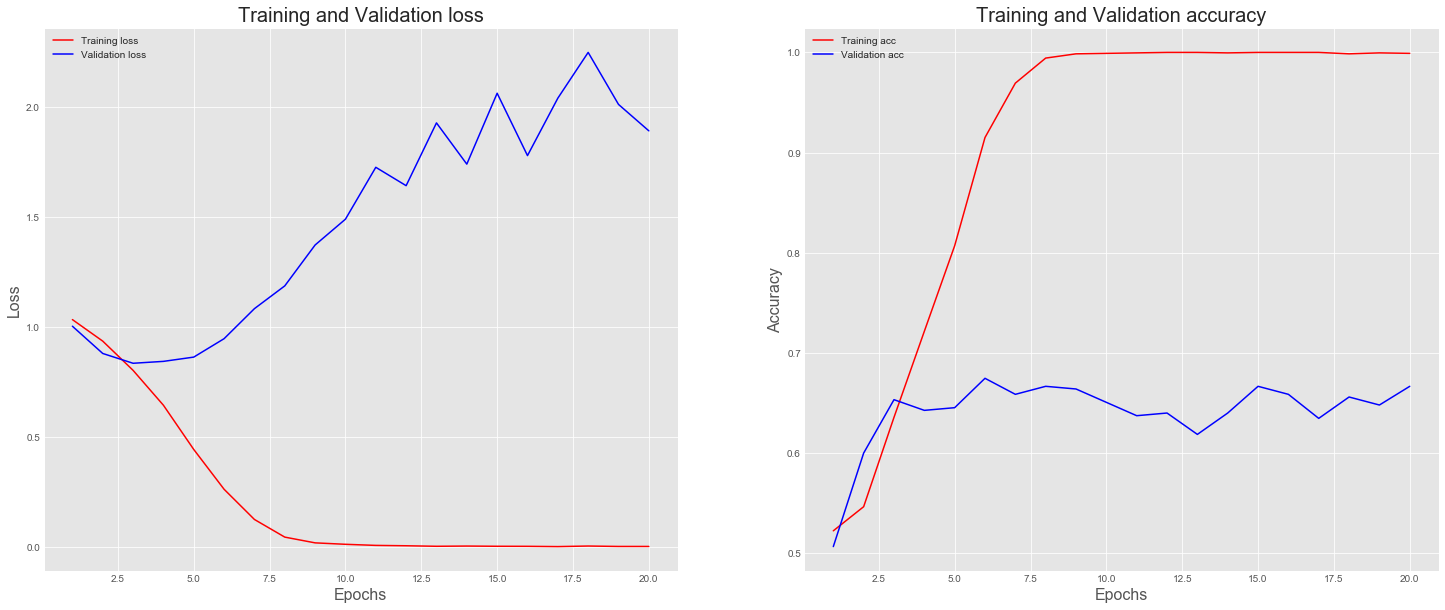

In [83]:
plt.style.use('ggplot')
# Assess baseline model performance
model_performance(history_baseline)

**Analysis of baseline model:** In a word, garbage. There is undeniable evidence of overfitting as the training loss decreased to 0, while the validation loss continues to trend upwards after 20 epochs. Additionally, the training accuracy leveled off at 100%, while the validation accuracy fluctuated around 65%. 

Since this model is a recurrent neural network, the sequence of the words passing through the network is important. Thus, the stopwords were included in the first iteration of this model. For the next iteration, the stopwords will be removed to determine if the inclusion of stopwords aided the model during the classification task. If there is no significant difference between the performance of the model on the data with and without stopwords, the stopwords will be removed for further training/regularization iterations.


In [88]:
# Create new training and test sets that have had the stopwords removed. 
train_x, test_x, train_y, test_y = preprocess(df, fraction=0.1, stop=True, max_seq_len=150)

In [89]:
# Fit the model the training data with stopwords removed
stopped_baseline = baseline.fit(train_x, train_y, epochs=20, batch_size=50, validation_split=0.15)

Train on 2119 samples, validate on 375 samples
Epoch 1/20
2119/2119 [==============================] - 7s 3ms/step - loss: 1.3728 - acc: 0.4299 - val_loss: 1.0077 - val_acc: 0.5013
Epoch 2/20
2119/2119 [==============================] - 7s 3ms/step - loss: 0.9246 - acc: 0.5234 - val_loss: 0.9951 - val_acc: 0.5440
Epoch 3/20
2119/2119 [==============================] - 8s 4ms/step - loss: 0.8081 - acc: 0.6130 - val_loss: 0.9915 - val_acc: 0.5387
Epoch 4/20
2119/2119 [==============================] - 8s 4ms/step - loss: 0.6691 - acc: 0.7079 - val_loss: 1.0397 - val_acc: 0.5707
Epoch 5/20
2119/2119 [==============================] - 8s 4ms/step - loss: 0.5122 - acc: 0.7980 - val_loss: 1.1035 - val_acc: 0.5440
Epoch 6/20
2119/2119 [==============================] - 8s 4ms/step - loss: 0.3622 - acc: 0.8697 - val_loss: 1.2832 - val_acc: 0.5200
Epoch 7/20
2119/2119 [==============================] - 8s 4ms/step - loss: 0.2748 - acc: 0.9070 - val_loss: 1.4399 - val_acc: 0.5787
Epoch 8/20
2119

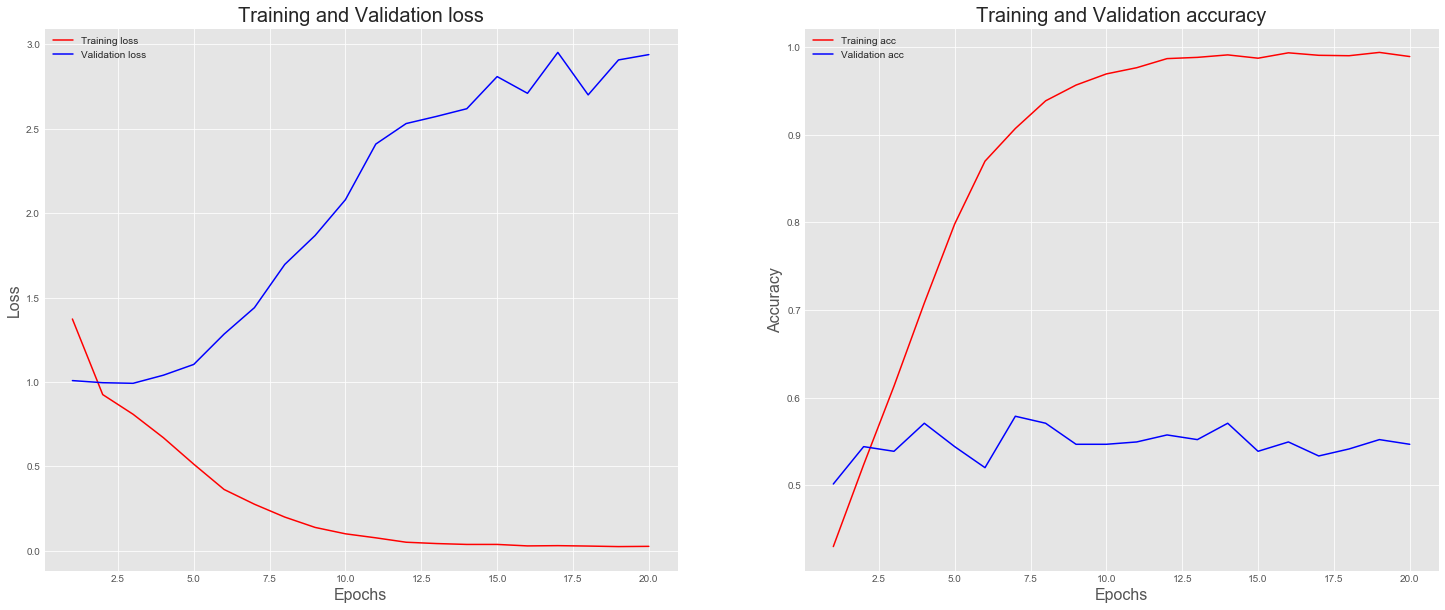

In [90]:
model_performance(stopped_baseline)

**Analysis of Baseline Model with Stopwords Removed:** Still garbage in terms of overfitting, but better garbage because the training time was a 5x faster than when the model trained on the texts containing the stopwords (2.3 mins as opposed to 10.7 mins). However, the validation accuracy scores of the model trained on the non-stopped texts performed roughly 10% better than the model trained on the stopped texts. Thus, non-stopped texts will be used for subsequent regularization iterations.

Strategies to improve model:
1. Add regularization layers
2. Increase dropout probability
3. Increase the amount of data used for training
4. Stop the epochs early


Additionally, since there was clear evidence of overfitting prior to the 10th epoch, we will reduce training epochs to 10 for subsequent iterations with regularization models.

In [91]:
# Create the training and test sets with non-stopped texts
train_x, test_x, train_y, test_y = preprocess(df, fraction=0.1, stop=False, max_seq_len=750)

In [92]:
# Create a model employing L1 regularization
regularize = Sequential()
regularize.add(Embedding(26000, 200))
regularize.add(Bidirectional(GRU(30, return_sequences=True)))
regularize.add(GlobalMaxPool1D())
regularize.add(Dense(70, kernel_regularizer=regularizers.l1(0.007), activation='relu'))
regularize.add(Dropout(0.3))
regularize.add(Dense(35, kernel_regularizer=regularizers.l1(0.007), activation='relu'))
regularize.add(Dropout(0.3))
regularize.add(Dense(3, activation='softmax'))

# Assemble the model with L1 regularization
regularize.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Fit the model to the training data
history_regularize = regularize.fit(train_x, train_y, epochs=10, batch_size=50, validation_split=0.15)

Train on 2119 samples, validate on 375 samples
Epoch 1/10
2119/2119 [==============================] - 33s 15ms/step - loss: 5.3598 - acc: 0.5040 - val_loss: 4.4034 - val_acc: 0.5893
Epoch 2/10
2119/2119 [==============================] - 33s 16ms/step - loss: 3.7403 - acc: 0.5286 - val_loss: 3.0060 - val_acc: 0.5893
Epoch 3/10
2119/2119 [==============================] - 33s 16ms/step - loss: 2.5233 - acc: 0.5286 - val_loss: 1.9746 - val_acc: 0.5893
Epoch 4/10
2119/2119 [==============================] - 32s 15ms/step - loss: 1.6633 - acc: 0.5286 - val_loss: 1.3097 - val_acc: 0.5893
Epoch 5/10
2119/2119 [==============================] - 32s 15ms/step - loss: 1.1527 - acc: 0.5290 - val_loss: 1.0029 - val_acc: 0.5893
Epoch 6/10
2119/2119 [==============================] - 32s 15ms/step - loss: 0.9543 - acc: 0.5630 - val_loss: 0.9611 - val_acc: 0.6347
Epoch 7/10
2119/2119 [==============================] - 32s 15ms/step - loss: 0.8694 - acc: 0.6404 - val_loss: 0.9452 - val_acc: 0.6427
E

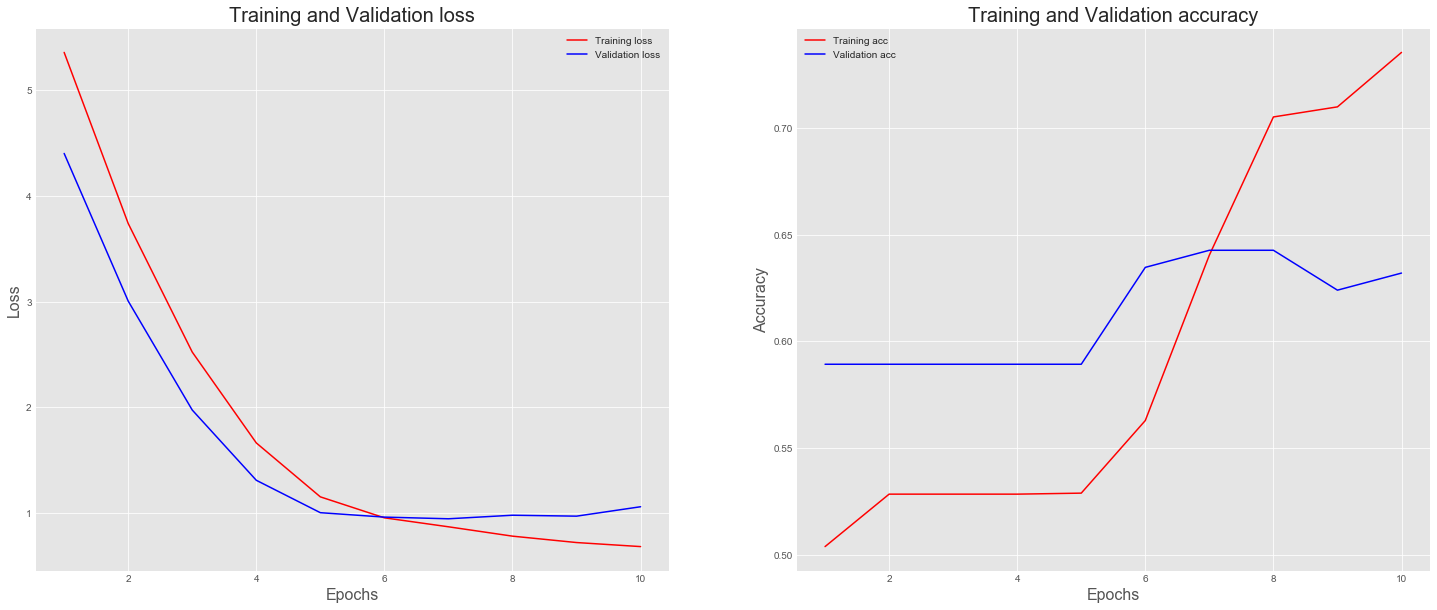

In [93]:
# Assess model performance with L1 regularization
model_performance(history_regularize)

**Analysis of L1 Regularization:** Adding L1 regularization to the two hidden dense layers reduced overfitting as the training and validation loss values are similar until the 7th epoch. They do however diverge at the 7th epoch and indicate overfitting. While the reduction in overfitting may look dramatic, the y-scale has a range of [0.5, 5.5], which is significantly larger than the y-scale of the previous two graphs ([0,3]). Additionally, the accuracy values were similar between the training and validation sets until the 7th epoch where the validation measures leveled off around 63% again. While the overall performance of the model still isn't great, this is an improvement from the baseline model.

In [95]:
# Create a model employing L2 regularization
regularize2 = Sequential()
regularize2.add(Embedding(26000, 200))
regularize2.add(Bidirectional(GRU(30, return_sequences=True)))
regularize2.add(GlobalMaxPool1D())
regularize2.add(Dense(70, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
regularize2.add(Dropout(0.3))
regularize2.add(Dense(35, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
regularize2.add(Dropout(0.3))
regularize2.add(Dense(3, activation='softmax'))

# Assemble the model with L2 regularization
regularize2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Fit the model to the training data
history_regularize2 = regularize2.fit(train_x, train_y, epochs=10, batch_size=50, validation_split=0.15)

Train on 2119 samples, validate on 375 samples
Epoch 1/10
2119/2119 [==============================] - 35s 16ms/step - loss: 1.9201 - acc: 0.5035 - val_loss: 1.5957 - val_acc: 0.5893
Epoch 2/10
2119/2119 [==============================] - 33s 16ms/step - loss: 1.4879 - acc: 0.5286 - val_loss: 1.2786 - val_acc: 0.5893
Epoch 3/10
2119/2119 [==============================] - 34s 16ms/step - loss: 1.1938 - acc: 0.5531 - val_loss: 1.0479 - val_acc: 0.6373
Epoch 4/10
2119/2119 [==============================] - 33s 16ms/step - loss: 0.9708 - acc: 0.6503 - val_loss: 0.9682 - val_acc: 0.6107
Epoch 5/10
2119/2119 [==============================] - 32s 15ms/step - loss: 0.7768 - acc: 0.7164 - val_loss: 0.9476 - val_acc: 0.6240
Epoch 6/10
2119/2119 [==============================] - 33s 15ms/step - loss: 0.5871 - acc: 0.8103 - val_loss: 0.9911 - val_acc: 0.6453
Epoch 7/10
2119/2119 [==============================] - 33s 15ms/step - loss: 0.4583 - acc: 0.8877 - val_loss: 1.1168 - val_acc: 0.6587
E

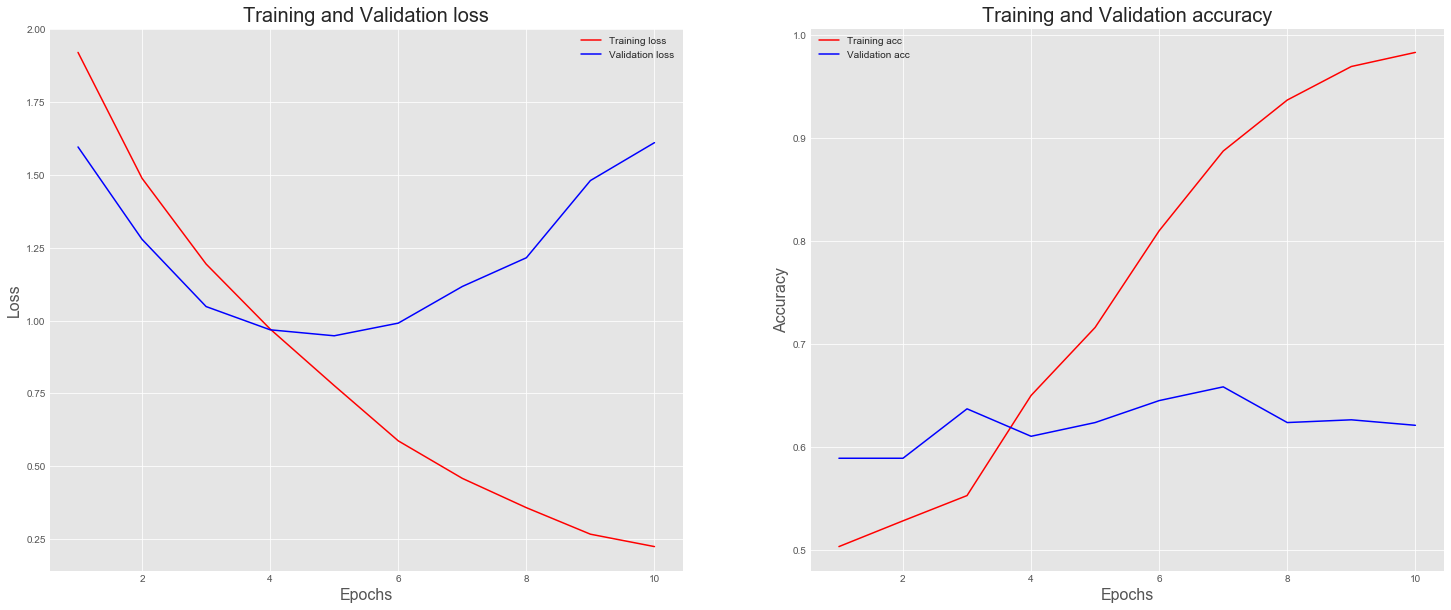

In [96]:
# Assess model performance with L2 regularization
model_performance(history_regularize2)

**Analysis of L2 Regularization:** Adding L2 regularization to the 2 hidden dense layers did not do much to correct the overfitting seen in the baseline model. Training and validation loss and accuracy measures diverge early in training (roughly 5th epoch). Additionally, there was no significant affect on validation accuracy scores in relation to other iterations tested thus far.


In [97]:
# Create a model employing dropout regularization
dropout = Sequential()
dropout.add(Embedding(26000, 200))
dropout.add(Bidirectional(GRU(30, return_sequences=True)))
dropout.add(GlobalMaxPool1D())
dropout.add(Dropout(0.4))
dropout.add(Dense(70, activation='relu'))
dropout.add(Dropout(0.4))
dropout.add(Dense(35, activation='relu'))
dropout.add(Dropout(0.4))
dropout.add(Dense(3, activation='softmax'))

# Assemble the model with dropout regularization
dropout.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Fit the model to the training data
history_dropout = dropout.fit(train_x, train_y, epochs=10, batch_size=50, validation_split=0.15)

Train on 2119 samples, validate on 375 samples
Epoch 1/10
2119/2119 [==============================] - 33s 16ms/step - loss: 1.0447 - acc: 0.4960 - val_loss: 0.9601 - val_acc: 0.5893
Epoch 2/10
2119/2119 [==============================] - 33s 16ms/step - loss: 1.0060 - acc: 0.5281 - val_loss: 0.9414 - val_acc: 0.5893
Epoch 3/10
2119/2119 [==============================] - 33s 16ms/step - loss: 0.9599 - acc: 0.5309 - val_loss: 0.8685 - val_acc: 0.5973
Epoch 4/10
2119/2119 [==============================] - 33s 15ms/step - loss: 0.8832 - acc: 0.5668 - val_loss: 0.8360 - val_acc: 0.6453
Epoch 5/10
2119/2119 [==============================] - 33s 16ms/step - loss: 0.7999 - acc: 0.6262 - val_loss: 0.8280 - val_acc: 0.6587
Epoch 6/10
2119/2119 [==============================] - 33s 16ms/step - loss: 0.7115 - acc: 0.6640 - val_loss: 0.8121 - val_acc: 0.6587
Epoch 7/10
2119/2119 [==============================] - 33s 16ms/step - loss: 0.5637 - acc: 0.7329 - val_loss: 0.8625 - val_acc: 0.6427
E

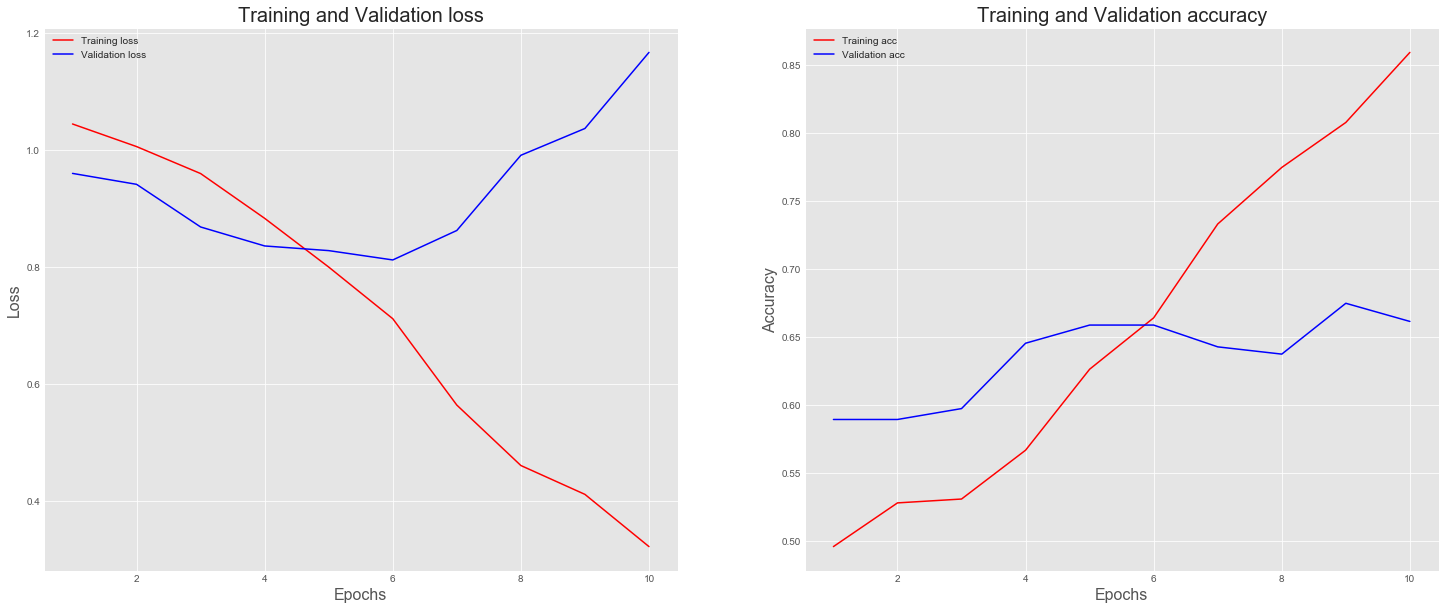

In [98]:
# Assess the model performance with dropout regularization
model_performance(history_dropout)

**Analysis of Increased Dropout:** Increasing the dropout probability and adding an additional dropout layer did reduce overfitting from the baseline model and result in the highest validation accuracy scores. However, the model does appear to begin overfitting around the 6th epoch.

A dropout layer was not added to the Bidirectional layer becasue droping a GRU neuron may drop a timestep as discussed here: https://stackoverflow.com/questions/50720670/using-dropout-with-keras-and-lstm-gru-cell

In [99]:
# Create larger training and test sets
train_x_more, test_x_more, train_Y_more, test_Y_more = preprocess(df, fraction=0.4, stop=False, max_seq_len=750)

In [100]:
# Create a model utilizing more of the total dataset
more_data = Sequential()
more_data.add(Embedding(26000, 200))
more_data.add(Bidirectional(GRU(30, return_sequences=True)))
more_data.add(GlobalMaxPool1D())
more_data.add(Dropout(0.4))
more_data.add(Dense(70, activation='relu'))
more_data.add(Dropout(0.4))
more_data.add(Dense(35, activation='relu'))
more_data.add(Dropout(0.4))
more_data.add(Dense(3, activation='softmax'))

# Assemble the model
more_data.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Fit the model to the larger training set
history_more_data = more_data.fit(train_x_more, train_Y_more, epochs=10, batch_size=50, validation_split=0.15)

Train on 8479 samples, validate on 1497 samples
Epoch 1/10
8479/8479 [==============================] - 134s 16ms/step - loss: 1.0069 - acc: 0.5213 - val_loss: 0.9107 - val_acc: 0.5271
Epoch 2/10
8479/8479 [==============================] - 134s 16ms/step - loss: 0.8962 - acc: 0.5774 - val_loss: 0.8235 - val_acc: 0.6232
Epoch 3/10
8479/8479 [==============================] - 133s 16ms/step - loss: 0.8090 - acc: 0.6184 - val_loss: 0.8026 - val_acc: 0.6493
Epoch 4/10
8479/8479 [==============================] - 131s 15ms/step - loss: 0.7394 - acc: 0.6426 - val_loss: 0.8172 - val_acc: 0.6373
Epoch 5/10
8479/8479 [==============================] - 134s 16ms/step - loss: 0.6397 - acc: 0.6879 - val_loss: 0.8478 - val_acc: 0.6553
Epoch 6/10
8479/8479 [==============================] - 132s 16ms/step - loss: 0.5413 - acc: 0.7383 - val_loss: 0.8891 - val_acc: 0.6440
Epoch 7/10
8479/8479 [==============================] - 132s 16ms/step - loss: 0.4557 - acc: 0.7782 - val_loss: 1.0303 - val_acc: 

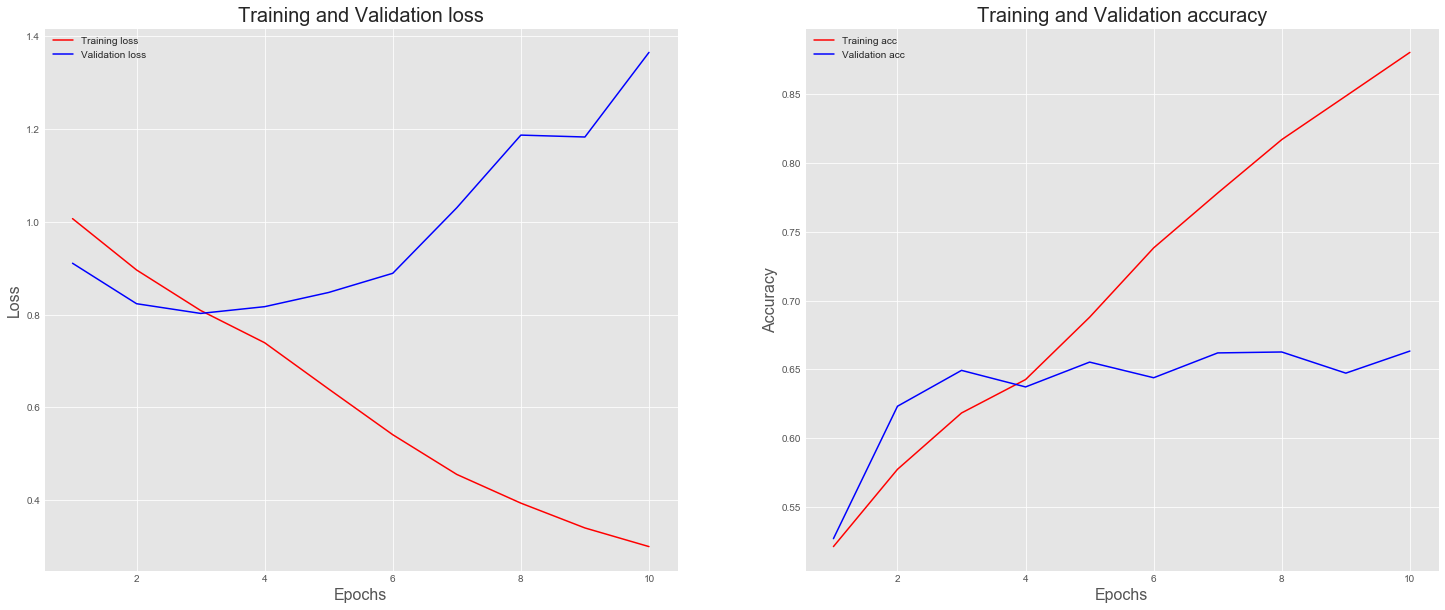

In [101]:
# Evaluate the model's performance with more data
model_performance(history_more_data)

**Analysis of Adding More Data:** Adding more training data seemed to only affect the run time as there is still clear overfitting and similar loss/accuracy measures from previous regularization iterations.

## 3b. Compare Performance with Classic Machine Learning Models

In [102]:
sample = df.sample(frac=0.1, random_state=16)
text = sample.text
target = sample.ideology_class

In [103]:
# Note, this cell takes roughly 1 min to run on 10% of the data
processed_opinions = list(map(tokenize_and_stop, text))

In [105]:
len(processed_opinions)

3118

In [111]:
total_vocab = set(word for doc in processed_opinions for word in doc)

In [112]:
len(total_vocab)

78870

In [113]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [114]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    # Need this for compatibility with SKLearn
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [115]:
from sklearn.neighbors import KNeighborsClassifier

In [116]:
rf =  Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ("Random Forest", RandomForestClassifier(n_estimators=100, verbose=True))])
log = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ('Logistic Regression', LogisticRegression())])
knn = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
               ('KNearest Neighbors', KNeighborsClassifier())])

models = [('Random Forest', rf),
          ("Logistic Regression", log),
          ("KNearest Neighbors", knn)]

In [118]:
scores = [(name, cross_val_score(model, processed_opinions, target, cv=2).mean()) for name, model, in models]
scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
/Users/kpokrass_pro/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kpokrass_pro/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be change

[('Random Forest', 0.605516356638871),
 ('Logistic Regression', 0.6090442591404747),
 ('KNearest Neighbors', 0.5615779345734445)]

# Conclusion

The recurrent, bidirectional neural network built during this project was able to classify the legal ideology of the case opinion author with 65% accuracy. However, the model displayed strong evidence of overfitting despite multiple interventions. While recurrent neural networks are a powerful tool for NLP and text classification, they only performed marginally better than several of the classic machine leraning models sampled in this project. Further efforts to the recurrent neural network developed in this project my yield performance improvements. However, most strategies would require computational expenses that would exceed the capabilities of the standard, personal-use, computers.

# Recommendations
- Classify the ideology of a justice based on their previous written work prior to developing case argument
- Tailor case arguments to central topics of the presiding justice's ideology


# Future Work
- Isolate and analyze case opinions for cases where the decision was not unanimous, as the majority and dissenting opinions are likely to better highlight the differences in legal ideology, and thus, improve model performance.
- Extend analysis to judges serving in lower courts to see if there is greater separation among these public officials
- Compare success of lawers arguing infront of justices with similar legal ideology to further assess if tailoring an argument to the ideology of the judge increases chances of winning the case.